In [1]:
!hostnamectl

   Static hostname: psh01com1hcom34
         Icon name: computer-server
           Chassis: server
        Machine ID: 4232d1115a5548e982021ba5a27af5c3
           Boot ID: 7722405a22e04dd3b701e19ac5a96705
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


# Comparing Different Methods for Calculating and Evaluating Sliding Window Scores

We have two methods for calculating TF-TG binding scores: 

1. Sum TF binding potential for all peaks targeting the same TG
2. Use individual TF-peak-TG scores

We also have different methods for assigning peaks to TGs
1. Nearest gene TSS to the peak
2. MIRA peak-TG
3. Cicero peak-TG

To evaluate the accuracy of the TF-TG scores, we will use the ChIP-seq ground truth, where the TG for TF-peak edges is assigned using the closest gene's TSS.

We will test the combinations of the calculation methods with the peak-TG assignments to see which are more discriminatory

##  Sliding Window Score Calculation

The sliding window score distributions are different for each TF depending on the TF's binding motif. To determine the probability that each TF will bind to each peak, the probabilities need to be standardized to account for these differences.

### Method 1: Summing peaks for TF-TG edges

The sliding window score for a peak will be determined by dividing the sum of the sliding window scores for a given TG by the sliding window score of all other sliding window scores for the TF:

$$\text{Sliding Window Score}_{\text{TF-TG}} = \frac{\sum_{\text{peak} \in \text{TG Peaks}}^{\text{TG peaks}}\text{sliding window score}_{\text{peak}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dev.notebooks.plotting as dev_plots
from typing import Union
import importlib
from grn_inference.utils import read_ground_truth, merge_dataset_with_ground_truth

cache_folder = "dev/notebooks/sliding_window_calculation_method_testing_cache"

In [2]:
def calculate_summed_tf_tg_score(sliding_window_with_targets: pd.DataFrame):
    # Group by TF and sum all sliding window scores
    sum_of_tf_peaks = (
        sliding_window_with_targets
        .groupby("source_id")["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"total_tf_score"})
        )
    
    # Group by TF-TG edge and sum for all peaks for that edge
    sum_of_tf_tg_peak_scores = (
        sliding_window_with_targets
        .groupby(["source_id", "target_id"])["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"tf_to_tg_peak_scores_summed"})
        )
    
    # Merge the total TF peaks and summed TF-TG edges
    sliding_window_sum_calculation_df = pd.merge(
        sum_of_tf_tg_peak_scores, 
        sum_of_tf_peaks, 
        how="left", 
        on="source_id"
        )
    
    
    sliding_window_sum_calculation_df["sliding_window_score"] = (
        sliding_window_sum_calculation_df["tf_to_tg_peak_scores_summed"] / sliding_window_sum_calculation_df["total_tf_score"]
        ) * 1e6
    # sliding_window_sum_df = sliding_window_sum_calculation_df[["source_id", "target_id", "sliding_window_score"]]
    
    return sliding_window_sum_calculation_df

### Method 2: Individual peaks for TF-TG edges

We also want to evaluate the performance of using each TF-peak-TG score rather than aggregating. For this, we use the following formula:

$$\text{Sliding Window Score}_{\text{TF-peak-TG}} = \frac{\text{sliding window score}_{\text{TF-peak-TG}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [3]:
def calculate_tf_peak_tg_score(sliding_window_with_targets: pd.DataFrame):
    # Group by TF and sum all sliding window scores
    sum_of_tf_peaks = (
        sliding_window_with_targets
        .groupby("source_id")["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"total_tf_score"})
        )
    
    # Merge the total TF peaks with the TF-peak-TG scores
    sliding_window_tf_peak_tg_calculation_df = pd.merge(
        sliding_window_with_targets, 
        sum_of_tf_peaks, 
        how="left", 
        on="source_id"
        ).rename(columns={"sliding_window_score":"tf_peak_tg_score"})
    
    # Calculate the final sliding window score by dividing each TF-peak-TG score by the sum of scores for the TF
    sliding_window_tf_peak_tg_calculation_df["sliding_window_score"] = (
        sliding_window_tf_peak_tg_calculation_df["tf_peak_tg_score"] / sliding_window_tf_peak_tg_calculation_df["total_tf_score"]
        ) * 1e6
    sliding_window_tf_peak_tg_df = sliding_window_tf_peak_tg_calculation_df[["source_id", "peak_id", "target_id", "sliding_window_score"]]
    
    return sliding_window_tf_peak_tg_df

## Functions for assigning peaks to TGs

We will use these functions later on in the script to assign TGs for each TF-peak edge using either the nearest gene TSS to the peak, the overlapping peak-TG edges from MIRA, or the overlapping peak-TG edges from Cicero.

### Assigning TG as nearest gene TSS to peak

In [4]:
def set_tg_as_closest_gene_tss(raw_sliding_window_scores: pd.DataFrame, peaks_gene_distance_file: str):
    # Read in the peaks to TG data and pick the closest gene for each peak (maximum TSS distance score)
    peaks_near_genes_df = pd.read_parquet(peaks_gene_distance_file, engine="pyarrow")

    closest_gene_to_peak_df = peaks_near_genes_df.sort_values("TSS_dist_score", ascending=False).groupby("peak_id").first()
    closest_gene_to_peak_df = closest_gene_to_peak_df[["target_id"]].reset_index()

    # Set the TG for each TF-peak edge as the closest gene to the peak
    sliding_window_closest_gene_df = pd.merge(raw_sliding_window_scores, closest_gene_to_peak_df, on=["peak_id"], how="left")
    return sliding_window_closest_gene_df

### Assigning TG using MIRA peak-TG

In [5]:
def set_tg_using_mira_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, mira_df: pd.DataFrame):
    sliding_window_mira_df = pd.merge(raw_sliding_window_scores, mira_df, on=["peak_id"], how="left")
    sliding_window_mira_df = sliding_window_mira_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_mira_df

### Assigning TG using Cicero peak-TG

In [6]:
def set_tg_using_cicero_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, cicero_df: pd.DataFrame):
    sliding_window_cicero_df = pd.merge(raw_sliding_window_scores, cicero_df, on=["peak_id"], how="left")
    sliding_window_cicero_df = sliding_window_cicero_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_cicero_df

## Loading the RN111 and RN115 Ground Truth Datasets

We will use the **RN111 BEELINE ChIP-seq** and **RN115 LOGOF knockout** TF-TG datasets as the ground truth datasets to label edges as either True (the TF-TG edge is in the ground truth) or False (the TF-TG edge is not in the ground truth).

### Loading RN111

In [7]:
rn111_chipseq_ground_truth = read_ground_truth("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv").drop(columns=["Relationship"])
rn111_chipseq_ground_truth['source_id'] = rn111_chipseq_ground_truth['source_id'].str.capitalize()
rn111_chipseq_ground_truth['target_id'] = rn111_chipseq_ground_truth['target_id'].str.capitalize()

### Loading RN115

In [8]:
rn115_ko_ground_truth = pd.read_csv("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN115_LOGOF_ESCAPE_Mouse_ESC.tsv", sep="\t")
rn115_ko_ground_truth = rn115_ko_ground_truth[["Source", "Target"]].rename(columns={"Source":"source_id", "Target":"target_id"})
rn115_ko_ground_truth["source_id"] = rn115_ko_ground_truth["source_id"].str.capitalize()
rn115_ko_ground_truth["target_id"] = rn115_ko_ground_truth["target_id"].str.capitalize()

### Loading ChIP-Atlas Ground Truth

In [9]:
chip_atlas_ground_truth = pd.read_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/ground_truth_files/chip_atlas_tf_peak_tg_dist.csv", header=0, index_col=None)
chip_atlas_ground_truth = chip_atlas_ground_truth[["source_id", "target_id", "distance"]]
chip_atlas_ground_truth["source_id"] = chip_atlas_ground_truth["source_id"].str.capitalize()
chip_atlas_ground_truth["target_id"] = chip_atlas_ground_truth["target_id"].str.capitalize()

## Reloading Saved Files

### Reloading DS011 Files

In [ ]:
ds011_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn111_df.parquet"))
ds011_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn111_df.parquet"))
ds011_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn111_df.parquet"))

ds011_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn115_df.parquet"))
ds011_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn115_df.parquet"))
ds011_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn115_df.parquet"))

ds011_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn111_df.parquet"))
ds011_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn111_df.parquet"))
ds011_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn111_df.parquet"))

ds011_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn115_df.parquet"))
ds011_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn115_df.parquet"))
ds011_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn115_df.parquet"))

### Reloading mESC Files

In [ ]:
mesc_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn111_df.parquet"))
mesc_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn111_df.parquet"))
mesc_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn111_df.parquet"))

mesc_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn115_df.parquet"))
mesc_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn115_df.parquet"))
mesc_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn115_df.parquet"))

mesc_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn111_df.parquet"))
mesc_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn111_df.parquet"))
mesc_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn111_df.parquet"))

mesc_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn115_df.parquet"))
mesc_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn115_df.parquet"))
mesc_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn115_df.parquet"))

### Reloading ChIP-seq Files

In [10]:
chipseq_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn111_df.parquet")
chipseq_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn115_df.parquet")
chipseq_gene_tss_tf_tg_sum_chip_atlas_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_chip_atlas_df.parquet")

chipseq_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn111_df.parquet")
chipseq_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn115_df.parquet")
chipseq_gene_tss_tf_peak_tg_chip_atlas_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_chip_atlas_df.parquet")

## DS011

### Reading in the peak-TG score files

We read in the raw sliding window scores, the MIRA peak-TG scores, and the Cicero peak-TG scores as DataFrames. We also find the path to the `peaks_near_genes.parquet` file, which is generated during the dataset preprocessing step for the sample. 

In [9]:
ds011_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/DS011_mESC/DS011_mESC_sample1/"
ds011_sliding_window_df = pd.read_parquet(os.path.join(ds011_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")

ds011_peak_to_gene_distance_file = os.path.join(ds011_output_dir, "peaks_near_genes.parquet")
ds011_mira_df = pd.read_parquet("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_full/ds011_full_mira_peak_to_tg_scores.parquet", engine="pyarrow")
ds011_cicero_peak_to_tg_df = pd.read_parquet(os.path.join(ds011_output_dir, "cicero_peak_to_tg_scores.parquet"), engine="pyarrow")

### Setting the TGs for the TF-peak edges using closest TSS, MIRA, or Cicero

We use the functions defined in the **Functions for assigning peaks to TGs** section to create three separate DataFrames, one for each peak-TG mapping method.

In [10]:
ds011_gene_tss_sliding_window_df = set_tg_as_closest_gene_tss(ds011_sliding_window_df, ds011_peak_to_gene_distance_file)
ds011_mira_sliding_window_df = set_tg_using_mira_peak_tg_edges(ds011_sliding_window_df, ds011_mira_df)
ds011_cicero_sliding_window_df = set_tg_using_cicero_peak_tg_edges(ds011_sliding_window_df, ds011_cicero_peak_to_tg_df)

### Evaluating summed TF-TG scores

We calculate the sliding window score using Method 1, which sums the sliding window scores for all peaks for a given TF-TG edge, then divides by the sum of all TF-peak sliding window scores for the TF.

$$\text{Sliding Window Score}_{\text{TF-TG}} = \frac{\sum_{\text{peak} \in \text{TG Peaks}}^{\text{TG peaks}}\text{sliding window score}_{\text{peak}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [11]:
ds011_gene_tss_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_gene_tss_sliding_window_df)
ds011_mira_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_mira_sliding_window_df)
ds011_cicero_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_cicero_sliding_window_df)

#### Label edges using RN111

In [12]:
ds011_gene_tss_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
ds011_mira_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
ds011_cicero_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )

In [13]:
ds011_gene_tss_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn111_df.parquet"))
ds011_mira_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn111_df.parquet"))
ds011_cicero_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn111_df.parquet"))

In [14]:
ds011_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn111_df.parquet"))
ds011_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn111_df.parquet"))
ds011_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


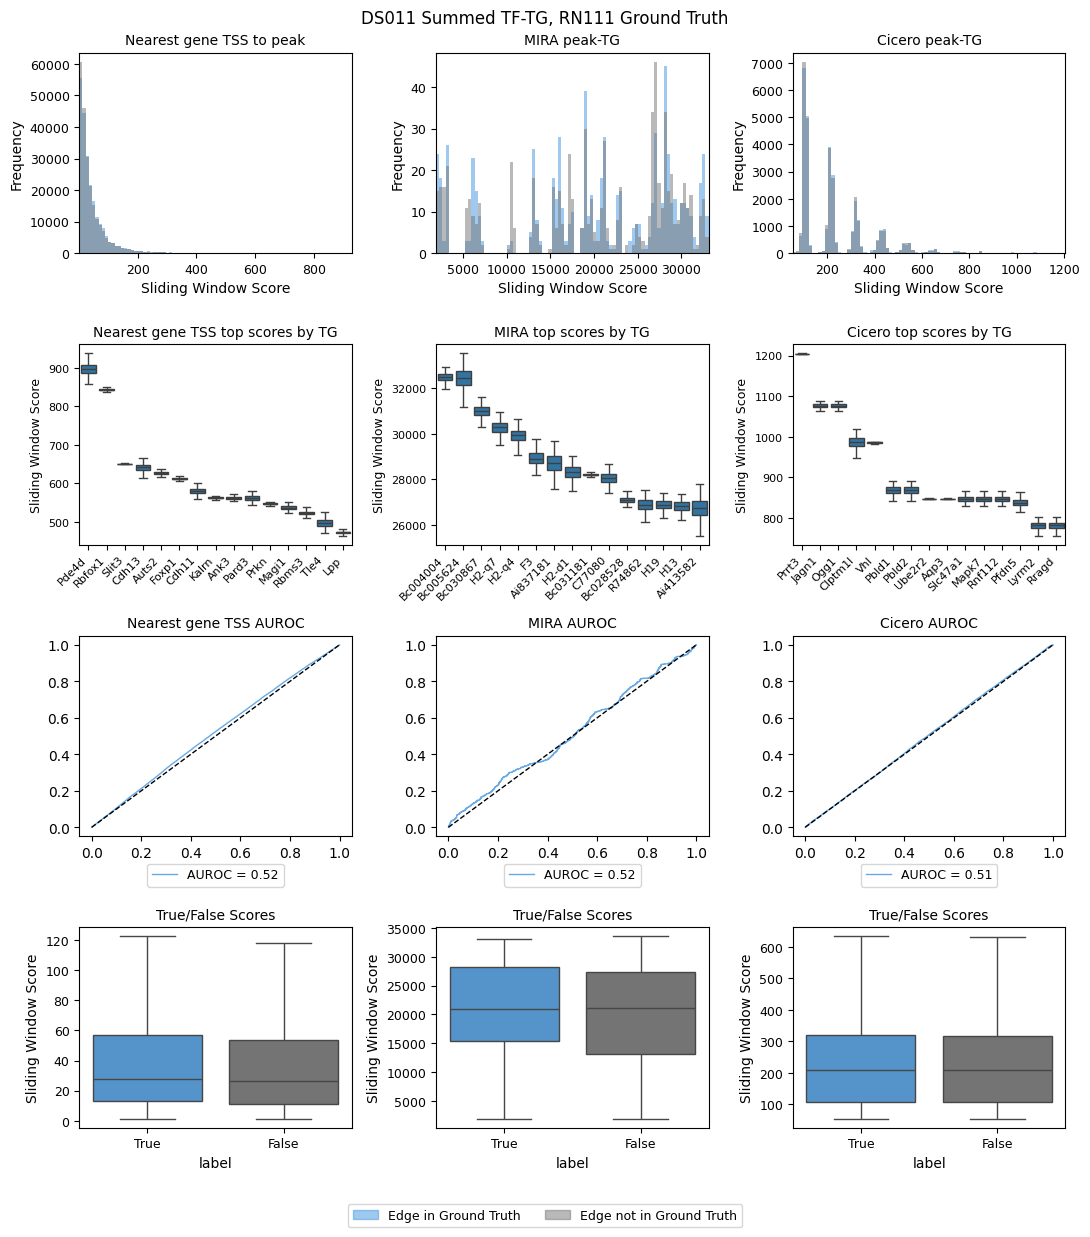

In [15]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_tg_sum_rn111_df,
    mira_df=ds011_mira_tf_tg_sum_rn111_df,
    cicero_df=ds011_cicero_tf_tg_sum_rn111_df,
    suptitle="DS011 Summed TF-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [16]:
ds011_gene_tss_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_tg_sum_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
ds011_mira_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_tg_sum_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
ds011_cicero_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_tg_sum_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [17]:
ds011_gene_tss_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn115_df.parquet"))
ds011_mira_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn115_df.parquet"))
ds011_cicero_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn115_df.parquet"))

In [18]:
ds011_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn115_df.parquet"))
ds011_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn115_df.parquet"))
ds011_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


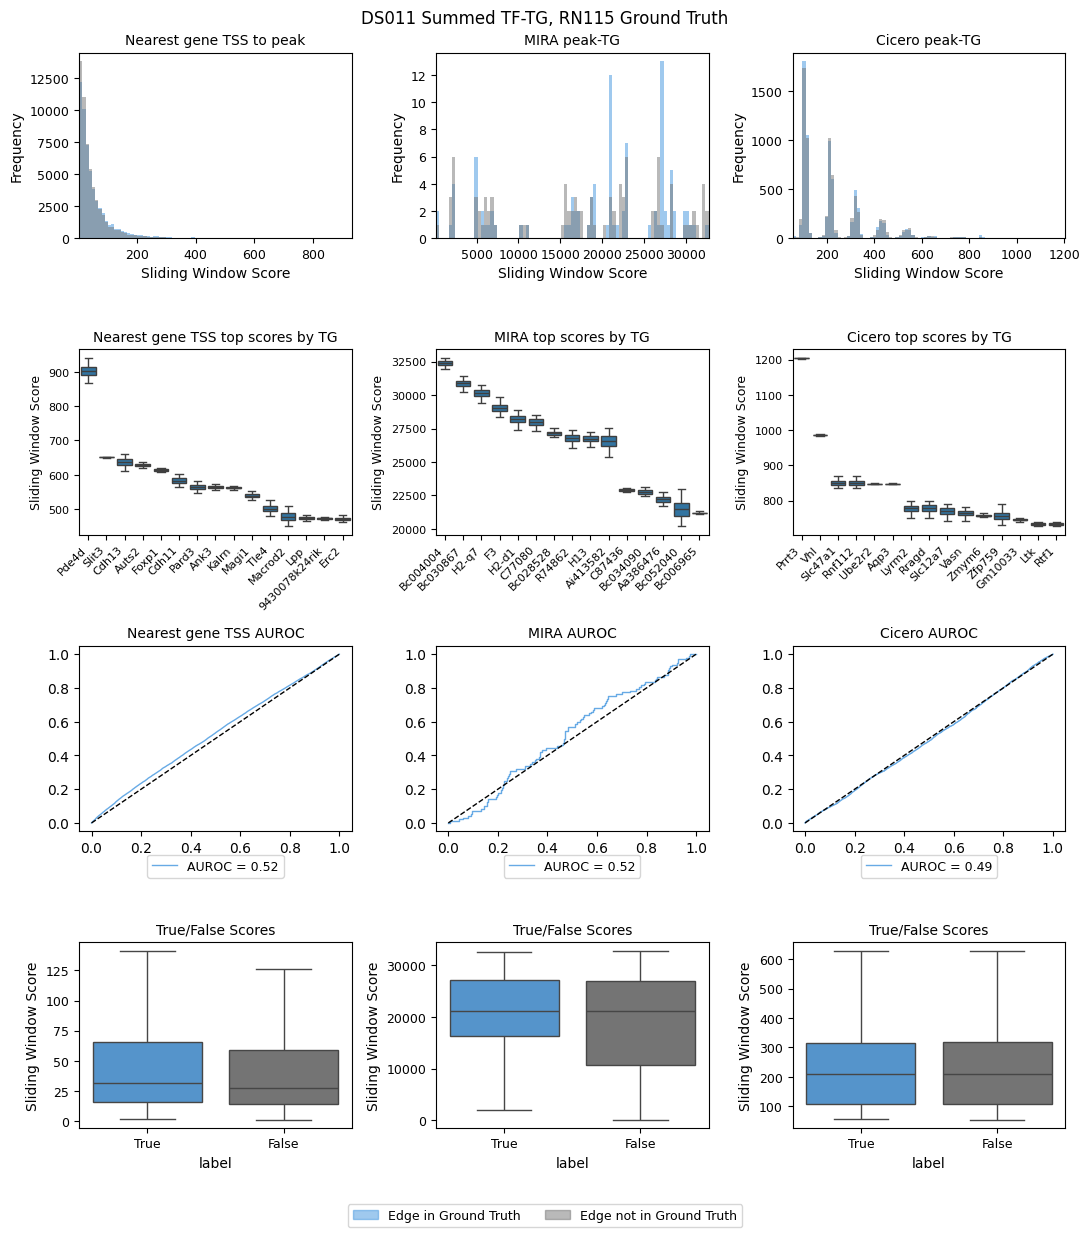

In [19]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_tg_sum_rn115_df,
    mira_df=ds011_mira_tf_tg_sum_rn115_df,
    cicero_df=ds011_cicero_tf_tg_sum_rn115_df,
    suptitle="DS011 Summed TF-TG, RN115 Ground Truth"
)

---

### Evaluating individual TF-peak-TG scores

Next, we evaluate the sliding window scores calculated using Method 2, which does not sum all of the peaks for each TF-TG edge, but instead keeps each TF-peak-TG edge as a separate score:

$$\text{Sliding Window Score}_{\text{TF-peak-TG}} = \frac{\text{sliding window score}_{\text{TF-peak-TG}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [20]:
ds011_gene_tss_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_gene_tss_sliding_window_df)
ds011_mira_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_mira_sliding_window_df)
ds011_cicero_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_cicero_sliding_window_df)

#### Label edges using RN111

In [21]:
ds011_gene_tss_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
ds011_mira_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
ds011_cicero_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )

In [22]:
ds011_gene_tss_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn111_df.parquet"))
ds011_mira_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn111_df.parquet"))
ds011_cicero_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn111_df.parquet"))

In [23]:
ds011_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn111_df.parquet"))
ds011_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn111_df.parquet"))
ds011_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


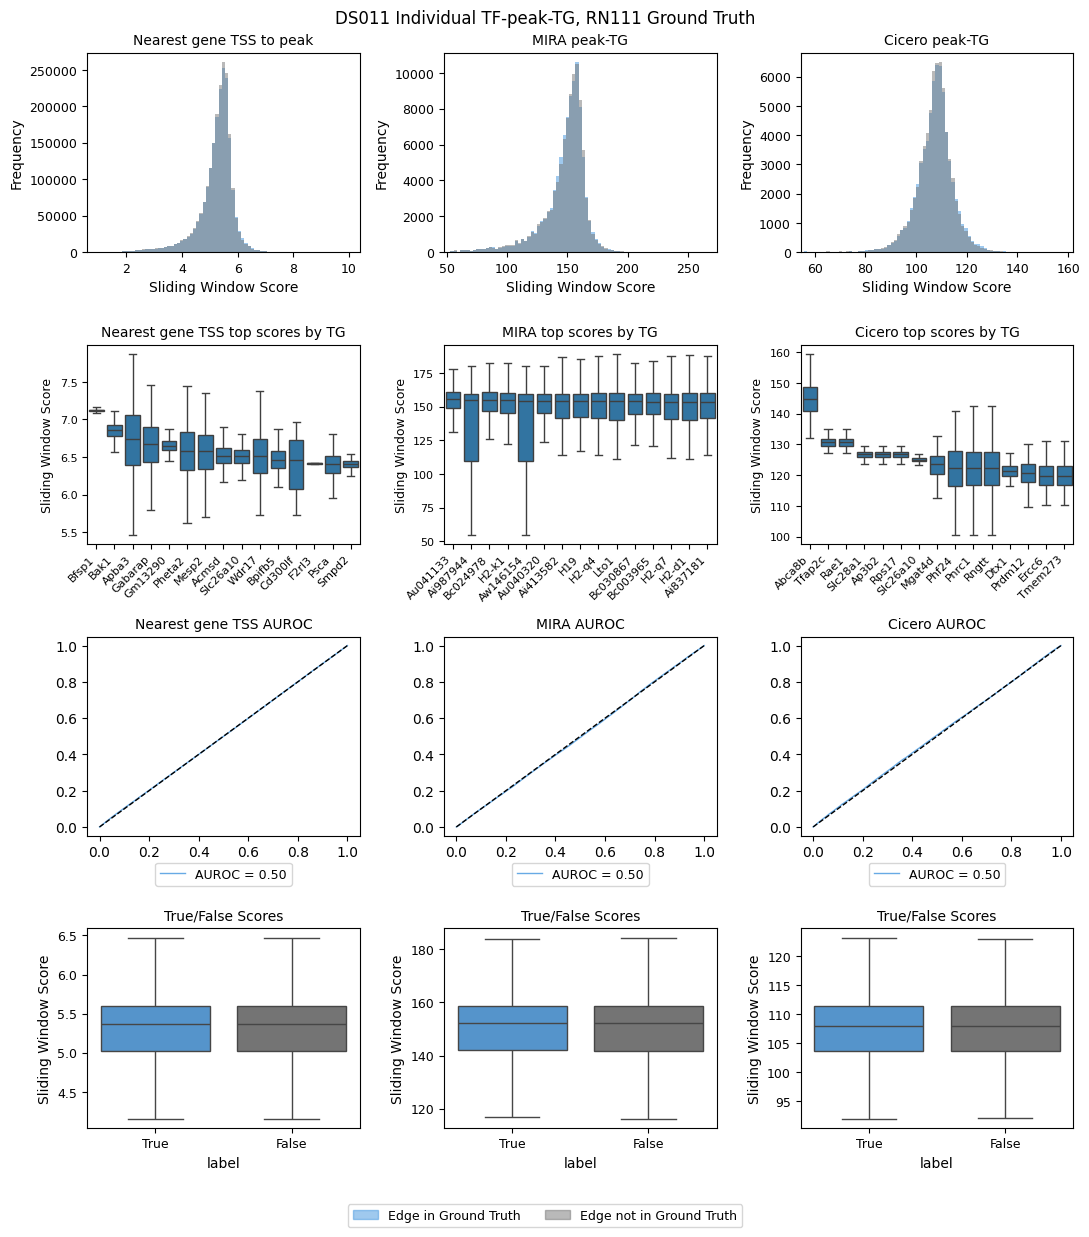

In [24]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_peak_tg_rn111_df,
    mira_df=ds011_mira_tf_peak_tg_rn111_df,
    cicero_df=ds011_cicero_tf_peak_tg_rn111_df,
    suptitle="DS011 Individual TF-peak-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [25]:
ds011_gene_tss_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_peak_tg_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
ds011_mira_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_peak_tg_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
ds011_cicero_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_peak_tg_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [26]:
ds011_gene_tss_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn115_df.parquet"))
ds011_mira_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn115_df.parquet"))
ds011_cicero_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn115_df.parquet"))

In [27]:
ds011_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn115_df.parquet"))
ds011_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn115_df.parquet"))
ds011_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


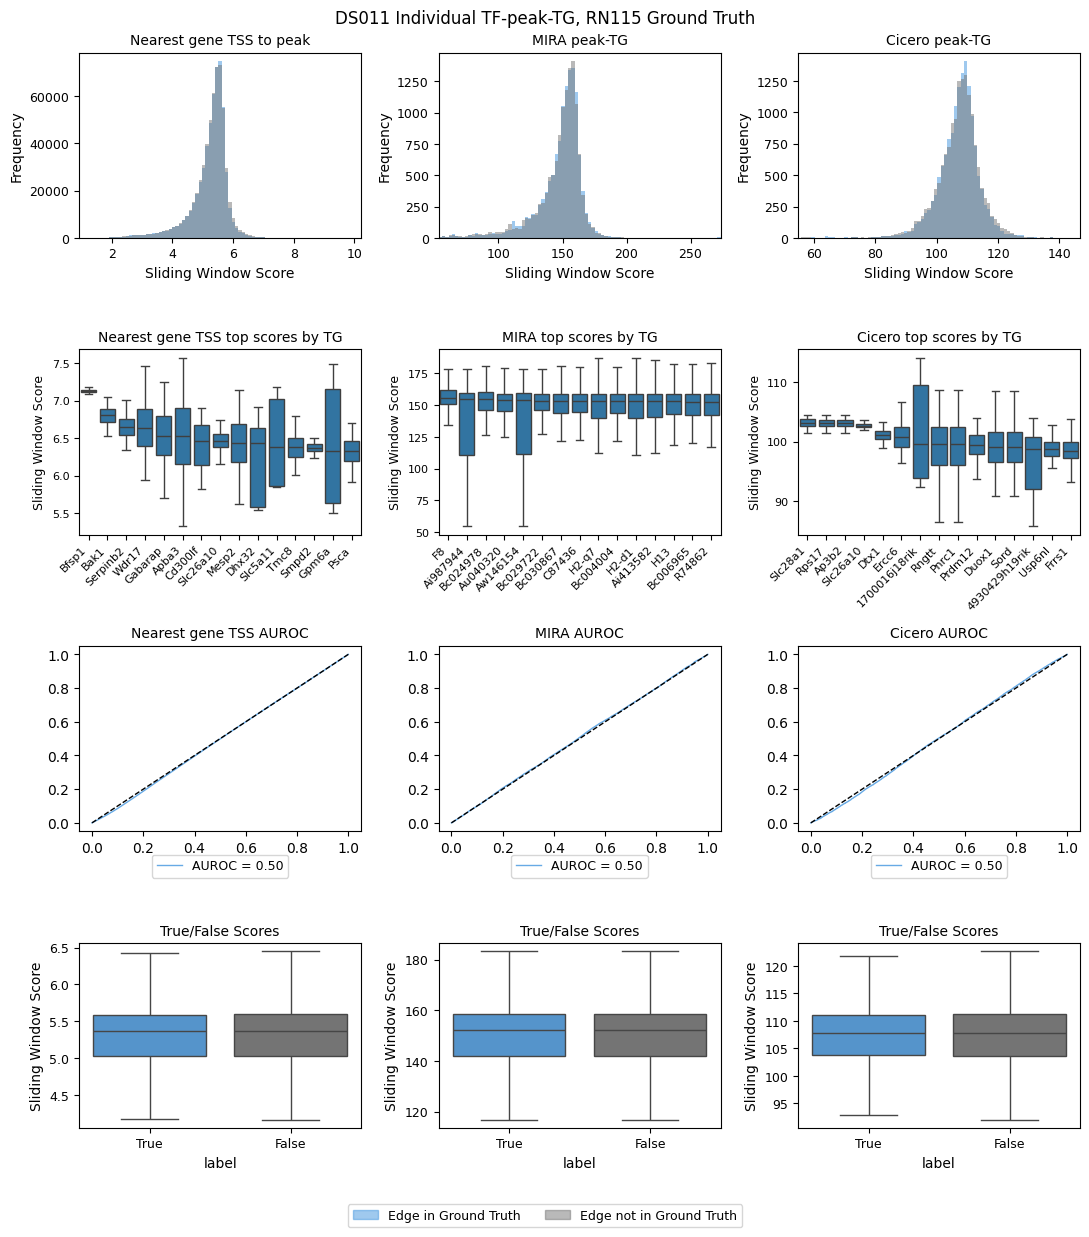

In [28]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_peak_tg_rn115_df,
    mira_df=ds011_mira_tf_peak_tg_rn115_df,
    cicero_df=ds011_cicero_tf_peak_tg_rn115_df,
    suptitle="DS011 Individual TF-peak-TG, RN115 Ground Truth"
)

---

## mESC Filtered L2 E7.5 Rep1

We first need to read in the sliding window scores, peak to gene distances, MIRA peak-TG scores, and the Cicero peak-TG scores for the mESC filtered L2 E7.5 Rep1 dataset.

### Reading in the peak-TG score files

In [29]:
mesc_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC/filtered_L2_E7.5_rep1"
mesc_sliding_window_df = pd.read_parquet(os.path.join(mesc_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")

mesc_peak_to_gene_distance_file = os.path.join(mesc_output_dir, "tmp/peak_to_gene_map.parquet")
mesc_mira_df = pd.read_parquet("/gpfs/Home/esm5360/MIRA/mira-datasets/mESC_filtered_L2_E7.5_rep1/mESC_E7.5_rep1_mira_peak_to_tg_scores_nonzero.parquet", engine="pyarrow")
mesc_cicero_peak_to_tg_df = pd.read_parquet(os.path.join(mesc_output_dir, "cicero_peak_to_tg_scores.parquet"), engine="pyarrow")

### Setting the TGs for the TF-peak edges using closest TSS, MIRA, or Cicero

In [30]:
mesc_gene_tss_sliding_window_df = set_tg_as_closest_gene_tss(mesc_sliding_window_df, mesc_peak_to_gene_distance_file)
mesc_mira_sliding_window_df = set_tg_using_mira_peak_tg_edges(mesc_sliding_window_df, mesc_mira_df)
mesc_cicero_sliding_window_df = set_tg_using_cicero_peak_tg_edges(mesc_sliding_window_df, mesc_cicero_peak_to_tg_df)

### Evaluating summed TF-TG scores

In [31]:
mesc_gene_tss_tf_tg_sum_df = calculate_summed_tf_tg_score(mesc_gene_tss_sliding_window_df)
mesc_mira_tf_tg_sum_df = calculate_summed_tf_tg_score(mesc_mira_sliding_window_df)
mesc_cicero_tf_tg_sum_df = calculate_summed_tf_tg_score(mesc_cicero_sliding_window_df)

#### Label edges using RN111

In [32]:
mesc_gene_tss_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
mesc_mira_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
mesc_cicero_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )

In [33]:
mesc_gene_tss_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn111_df.parquet"))
mesc_mira_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn111_df.parquet"))
mesc_cicero_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn111_df.parquet"))

In [34]:
mesc_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn111_df.parquet"))
mesc_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn111_df.parquet"))
mesc_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


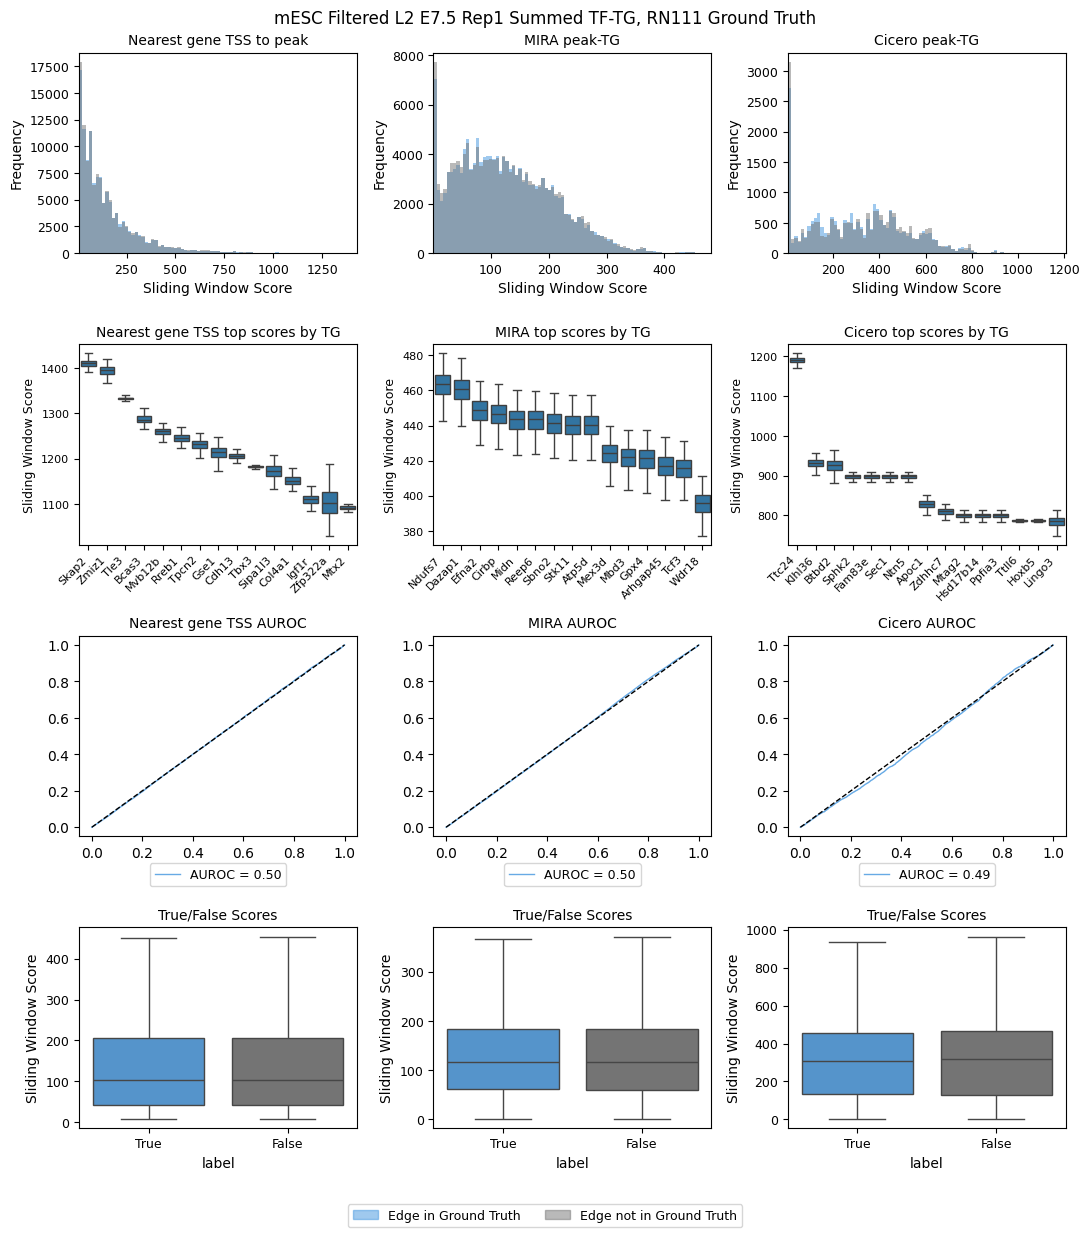

In [35]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_tg_sum_rn111_df,
    mira_df=mesc_mira_tf_tg_sum_rn111_df,
    cicero_df=mesc_cicero_tf_tg_sum_rn111_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Summed TF-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [36]:
mesc_gene_tss_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_tg_sum_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
mesc_mira_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_tg_sum_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
mesc_cicero_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_tg_sum_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [37]:
mesc_gene_tss_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn115_df.parquet"))
mesc_mira_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn115_df.parquet"))
mesc_cicero_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn115_df.parquet"))

In [38]:
mesc_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn115_df.parquet"))
mesc_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn115_df.parquet"))
mesc_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


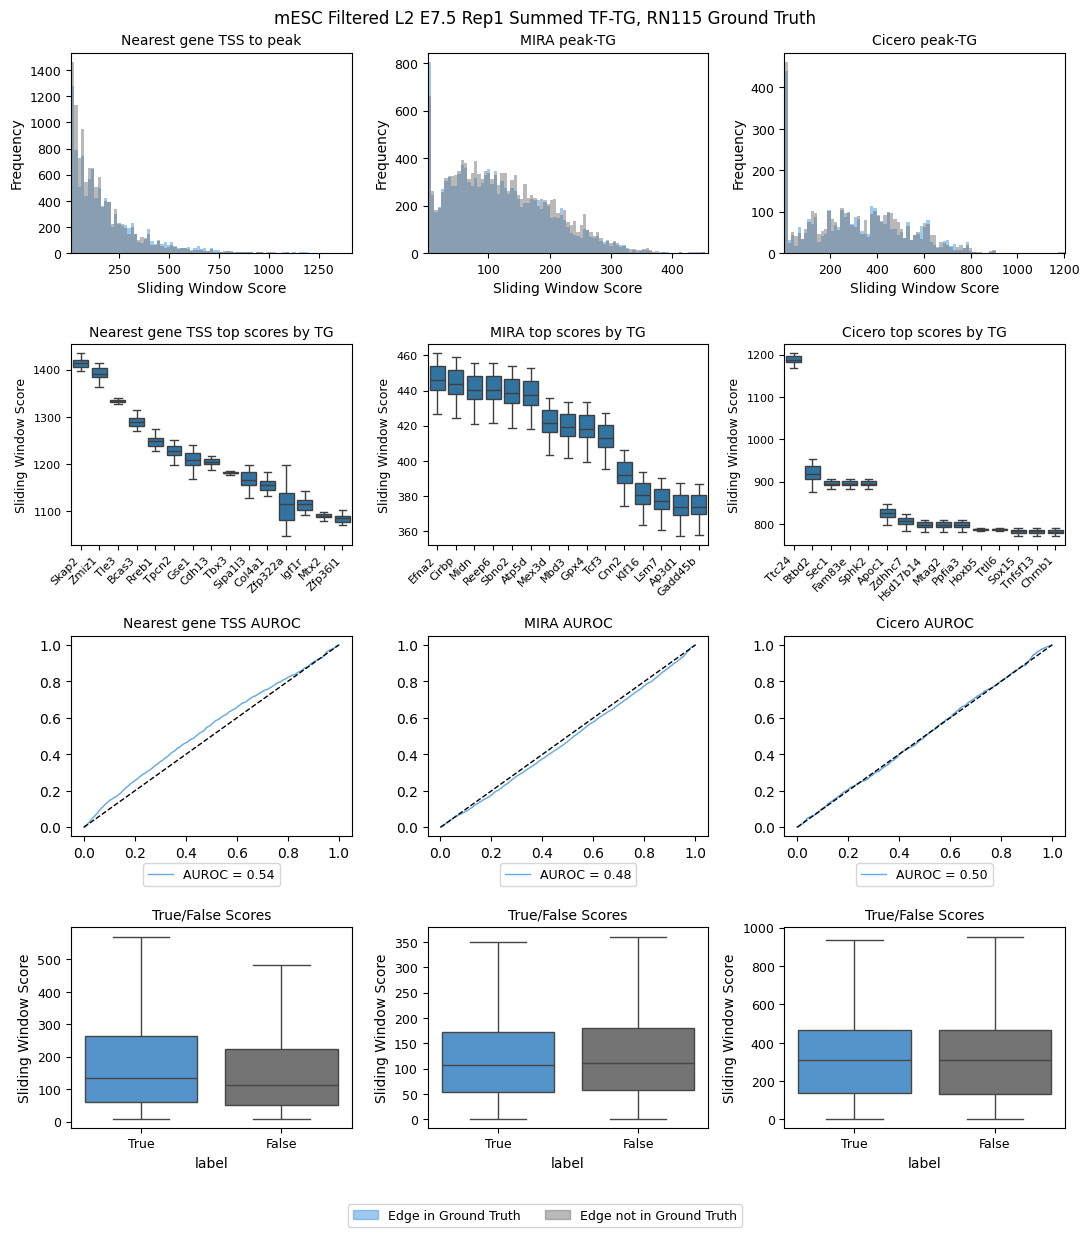

In [39]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_tg_sum_rn115_df,
    mira_df=mesc_mira_tf_tg_sum_rn115_df,
    cicero_df=mesc_cicero_tf_tg_sum_rn115_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Summed TF-TG, RN115 Ground Truth"
)

### Evaluating individual TF-peak-TG scores

In [40]:
mesc_gene_tss_tf_peak_tg_df = calculate_tf_peak_tg_score(mesc_gene_tss_sliding_window_df)
mesc_mira_tf_peak_tg_df = calculate_tf_peak_tg_score(mesc_mira_sliding_window_df)
mesc_cicero_tf_peak_tg_df = calculate_tf_peak_tg_score(mesc_cicero_sliding_window_df)

#### Label edges using RN111

In [41]:
mesc_gene_tss_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
mesc_mira_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
mesc_cicero_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )



In [42]:
mesc_gene_tss_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn111_df.parquet"))
mesc_mira_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn111_df.parquet"))
mesc_cicero_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn111_df.parquet"))

In [43]:
mesc_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn111_df.parquet"))
mesc_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn111_df.parquet"))
mesc_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


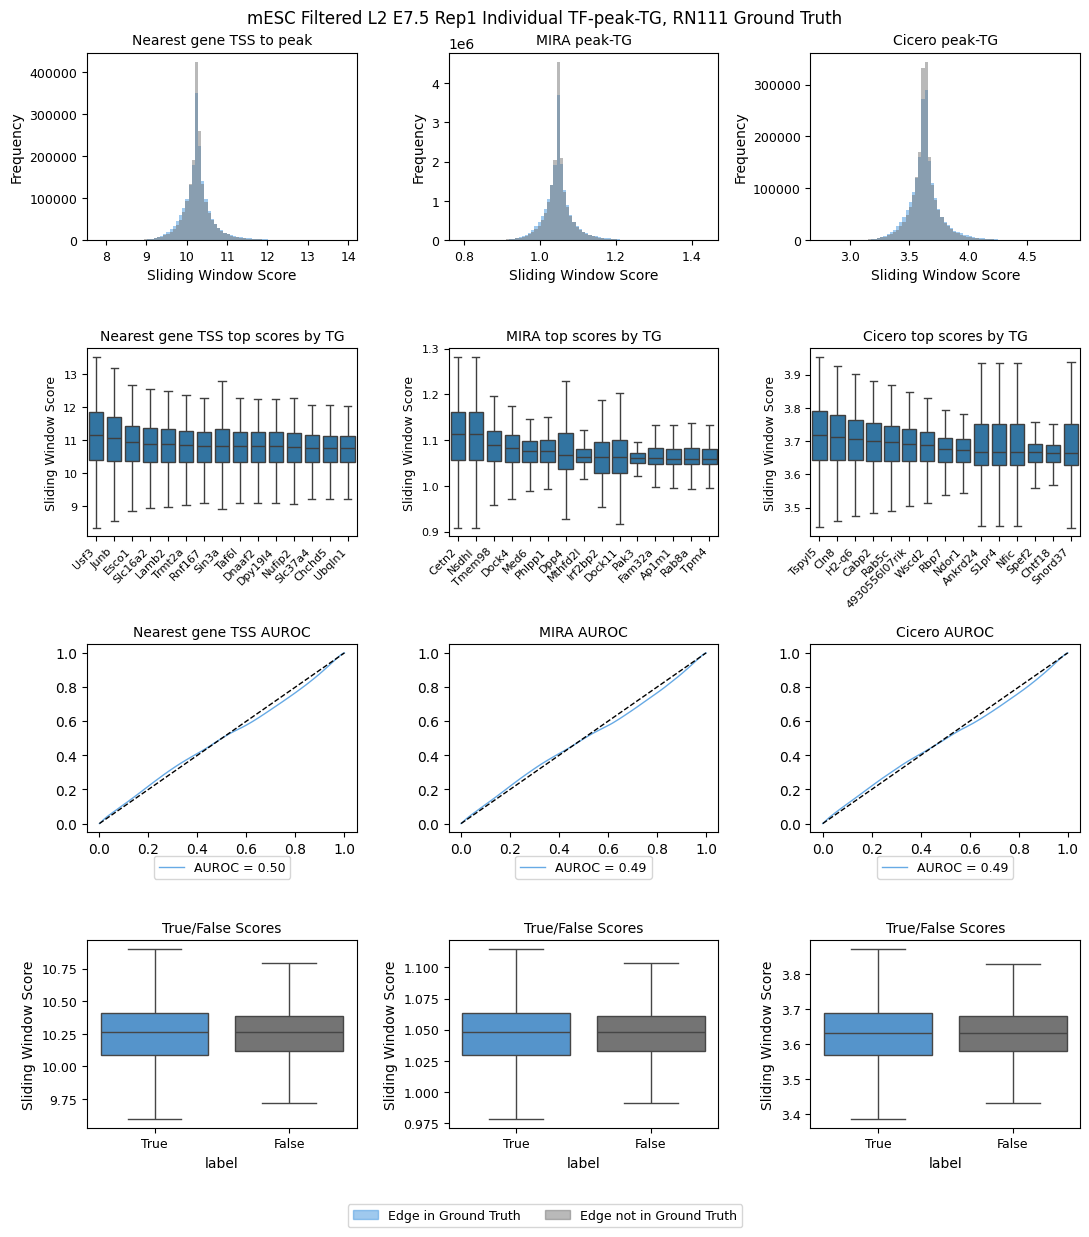

In [44]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_peak_tg_rn111_df,
    mira_df=mesc_mira_tf_peak_tg_rn111_df,
    cicero_df=mesc_cicero_tf_peak_tg_rn111_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Individual TF-peak-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [45]:
mesc_gene_tss_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_peak_tg_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
mesc_mira_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_peak_tg_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
mesc_cicero_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_peak_tg_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [46]:
mesc_gene_tss_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn115_df.parquet"))
mesc_mira_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn115_df.parquet"))
mesc_cicero_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn115_df.parquet"))

In [47]:
mesc_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn115_df.parquet"))
mesc_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn115_df.parquet"))
mesc_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


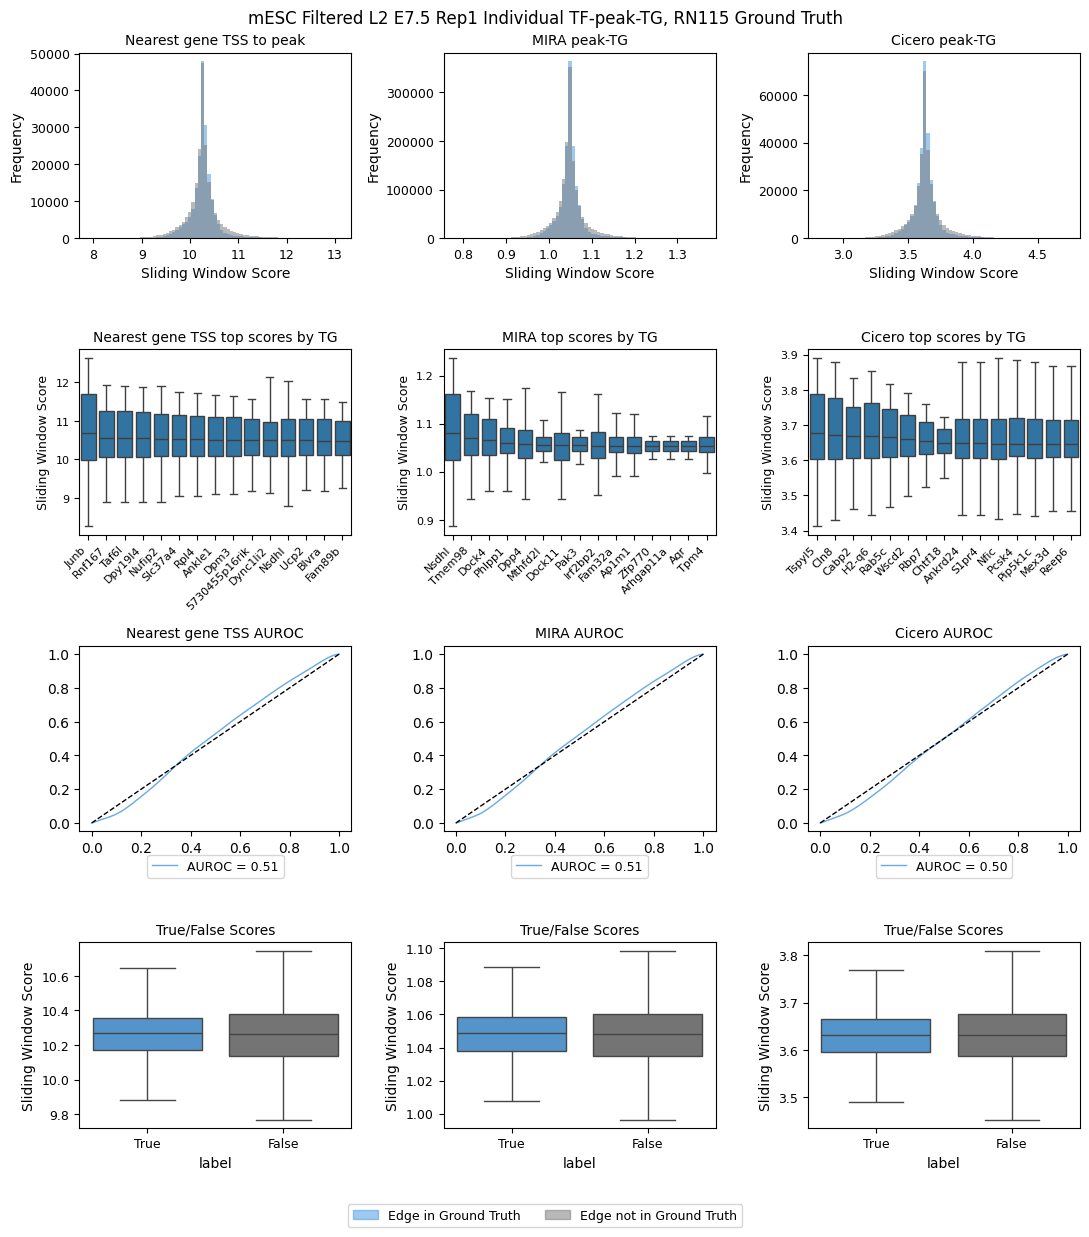

In [48]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_peak_tg_rn115_df,
    mira_df=mesc_mira_tf_peak_tg_rn115_df,
    cicero_df=mesc_cicero_tf_peak_tg_rn115_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Individual TF-peak-TG, RN115 Ground Truth"
)

---

## ChIP-seq

As a control, we want to test how well the sliding window score method works for ChIP-seq datasets, where we know the TF-peak binding. We used a ChIP-seq dataset for mouse embryonic cells from ChIP-Atlas. See `chipseq_sliding_window.ipynb` for the process used. We will only be able to evaluate mapping TGs using the nearest gene TSS method.

### Reading in the peak-TG score files

In [12]:
chipseq_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window"
chipseq_sliding_window_df = pd.read_parquet(os.path.join(chipseq_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")
chipseq_sliding_window_df

,peak_id,source_id,sliding_window_score
0,chr17:46704666-46705502,Ascl1,18836.157784
1,chr17:3456010-3456318,Ascl1,6543.452178
2,chr17:56255512-56256229,Ascl1,15508.133754
3,chr17:69382560-69382744,Ascl1,4256.191542
4,chr17:86555341-86555555,Ascl1,4312.891574
...,...,...,...
86068,chr11:51936197-51936397,Zfp335,7371.634079
86069,chr11:100846598-100846664,Zfp335,2121.398070
86070,chr11:108891288-108891643,Zfp335,13014.262983
86071,chr11:87771063-87771282,Zfp335,8039.550073


The ChIP-Atlas TF-peak-nearest gene TSS file is loaded. The TF-peak interactions in the ChIP-Atlas peaks will act as the true edges. Sliding window scores are calculated between every TF and peak, so all possible TF-peak edges have a score. We expect higher scores for TF-peak edges that are in the ChIP-Atlas dataframe if the sliding window scoring method is working.

In [13]:
# Load in the TF-peak-nearest gene TSS distance ChIP-Atlas edge file
chip_atlas_edges_full = pd.read_csv("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/ground_truth_files/chip_atlas_tf_peak_tg_dist.csv", header=0, index_col=None)
chip_atlas_edges_full = chip_atlas_edges_full[["source_id", "peak_id", "target_id", "distance"]]
chip_atlas_edges_full["source_id"] = chip_atlas_edges_full["source_id"].str.capitalize()
chip_atlas_edges_full["target_id"] = chip_atlas_edges_full["target_id"].str.capitalize()

In [14]:
# Merge the sliding window score TF-peak edges with the ChIP-Atlas edges
chipseq_gene_tss_sliding_window_df = pd.merge(chipseq_sliding_window_df, chip_atlas_edges_full, on="peak_id", how="inner")
chipseq_gene_tss_sliding_window_df.head()

,peak_id,source_id_x,sliding_window_score,source_id_y,target_id,distance
0,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0
1,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0
2,chr17:3456010-3456318,Ascl1,6543.452178,Ctcf,Tiam2,25996
3,chr17:56255512-56256229,Ascl1,15508.133754,Ctcf,Fem1a,563
4,chr17:69382560-69382744,Ascl1,4256.191542,Ctcf,Zbtb14,430


After merging the sliding window score TF-peak edges with the TF-peak edges from ChIP-Atlas, we can split the merged dataframe based on whether or not the edge is shared between the sliding window score dataframe and the ChIP-Atlas dataframe.

In [15]:
tf_peak_edges_in_chipatlas = chipseq_gene_tss_sliding_window_df[chipseq_gene_tss_sliding_window_df["source_id_x"] == chipseq_gene_tss_sliding_window_df["source_id_y"]]
tf_peak_edges_not_in_chipatlas = chipseq_gene_tss_sliding_window_df[chipseq_gene_tss_sliding_window_df["source_id_x"] != chipseq_gene_tss_sliding_window_df["source_id_y"]]

To see if the sliding window scores are higher for ChIP-Atlas edges We can plot boxplots of the score distributions

In [16]:
true_scores = tf_peak_edges_in_chipatlas["sliding_window_score"].rename("Sliding Window Scores for\n Edges in ChIP-Atlas")
false_scores = tf_peak_edges_not_in_chipatlas["sliding_window_score"].rename("Sliding Window Scores for\n Edges Not in ChIP-Atlas")
true_false_chip_atlas_scores_merged = pd.merge(
    true_scores,
    false_scores,
    left_index=True,
    right_index=True,
    how="outer"
)
true_false_chip_atlas_scores_merged

,Sliding Window Scores for\n Edges in ChIP-Atlas,Sliding Window Scores for\n Edges Not in ChIP-Atlas
0,NaN,18836.157784
1,NaN,18836.157784
2,NaN,6543.452178
3,NaN,15508.133754
4,NaN,4256.191542
...,...,...
8094127,NaN,7371.634079
8094128,NaN,2121.398070
8094129,NaN,13014.262983
8094130,NaN,8039.550073


Text(0.5, 1.0, 'Sliding Window Scores for ChIP-Atlas TFs and peaks')

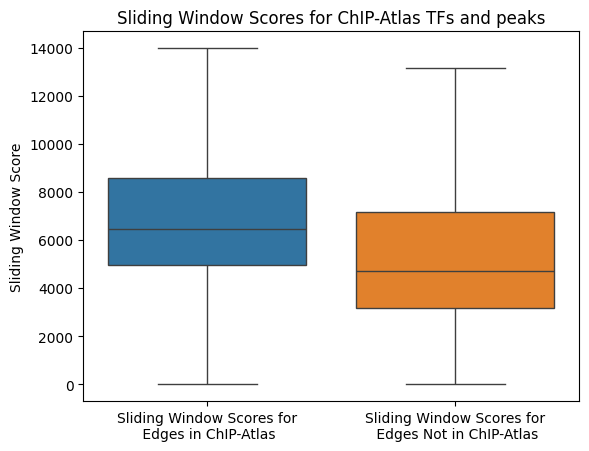

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.Figure()
a = sns.boxplot(data=true_false_chip_atlas_scores_merged, showfliers=False)
a.set_ylabel("Sliding Window Score")
a.set_title("Sliding Window Scores for ChIP-Atlas TFs and peaks")

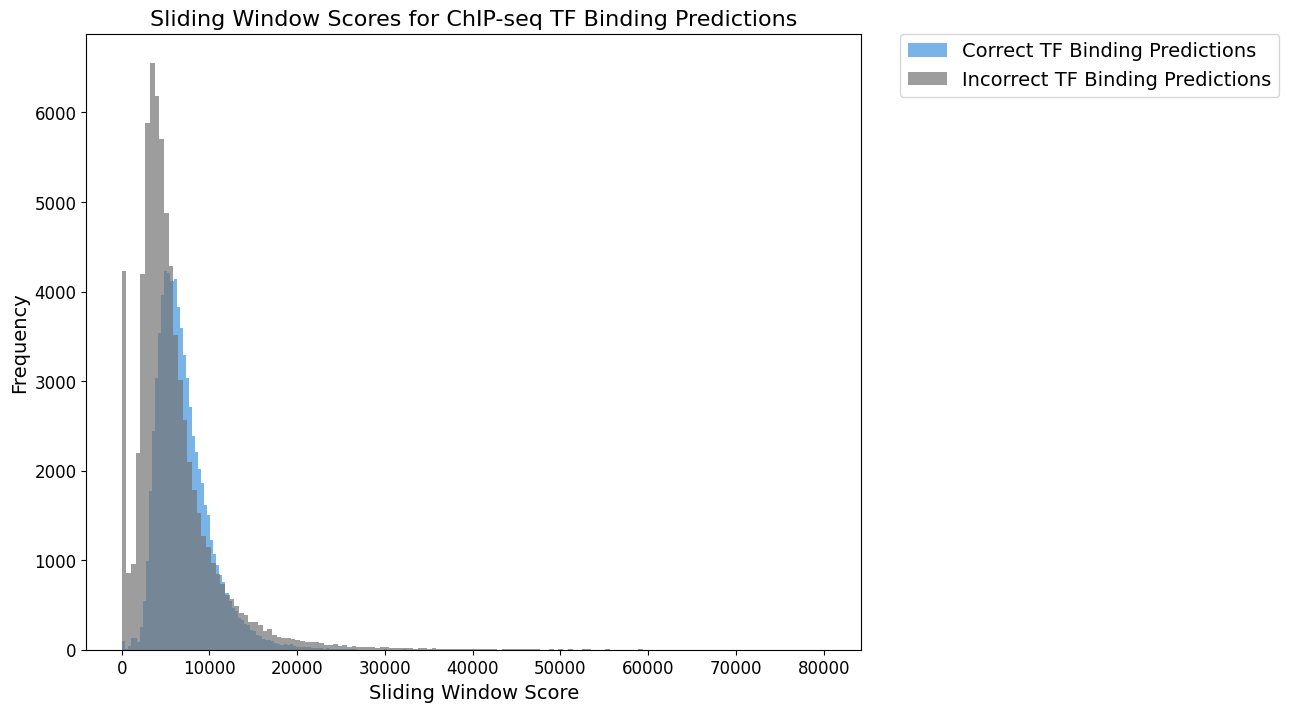

In [14]:
false_scores_balanced = true_false_chip_atlas_scores_merged["Sliding Window Scores for\n Edges Not in ChIP-Atlas"].sample(n=len(true_false_chip_atlas_scores_merged["Sliding Window Scores for\n Edges in ChIP-Atlas"].dropna()))

plt.figure(figsize=(10,8))
plt.hist(
    true_false_chip_atlas_scores_merged["Sliding Window Scores for\n Edges in ChIP-Atlas"],
    bins=150,
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)
plt.hist(
    false_scores_balanced,
    bins=150,
    alpha=0.7,
    color='#747474',
    label="Incorrect TF Binding Predictions"
)
plt.title("Sliding Window Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("Sliding Window Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
# plt.savefig("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window/chipseq_sliding_window_histogram.png", dpi=200)

plt.show()

### Differences between True and False ChIP-Atlas scores

We want to know what differentiates True scores from False scores to improve the method. We want to answer:

1. Does the size of the peak make a difference?
2. Does the chromosome that the peak is on make a difference?
3. Does the distance between the peak and the closest TG make a difference?

In [15]:
chipseq_gene_tss_sliding_window_df.head()

,peak_id,source_id_x,sliding_window_score,source_id_y,target_id,distance
0,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0
1,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0
2,chr17:3456010-3456318,Ascl1,6543.452178,Ctcf,Tiam2,25996
3,chr17:56255512-56256229,Ascl1,15508.133754,Ctcf,Fem1a,563
4,chr17:69382560-69382744,Ascl1,4256.191542,Ctcf,Zbtb14,430


In [17]:
def find_peak_length(df: pd.DataFrame, peak_col_name: str = "peak_id"):
    df = df.copy()
    
    peak_col = df[peak_col_name]
    
    peak_col_split = peak_col.str.extract(r'(chr[\w]+):([0-9]+)-([0-9]+)').dropna()
    df["peak_length"] = np.abs(peak_col_split[2].astype(int) - peak_col_split[1].astype(int))
    
    return df

peak_len_df = find_peak_length(chipseq_gene_tss_sliding_window_df.drop_duplicates())
peak_len_df

,peak_id,source_id_x,sliding_window_score,source_id_y,target_id,distance,peak_length
0,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0,836
2,chr17:3456010-3456318,Ascl1,6543.452178,Ctcf,Tiam2,25996,308
3,chr17:56255512-56256229,Ascl1,15508.133754,Ctcf,Fem1a,563,717
4,chr17:69382560-69382744,Ascl1,4256.191542,Ctcf,Zbtb14,430,184
5,chr17:86555341-86555555,Ascl1,4312.891574,Ctcf,Epas1,198308,214
...,...,...,...,...,...,...,...
8094127,chr11:51936197-51936397,Zfp335,7371.634079,Ctcf,Cdkn2aipnl,31233,200
8094128,chr11:100846598-100846664,Zfp335,2121.398070,Smarca4,Stat5b,3917,66
8094129,chr11:108891288-108891643,Zfp335,13014.262983,Rnf2,Axin2,28705,355
8094130,chr11:87771063-87771282,Zfp335,8039.550073,Rad21,Tspoap1,10523,219


In [18]:
true_scores_df = peak_len_df[peak_len_df["source_id_x"] == peak_len_df["source_id_y"]]
false_scores_df = peak_len_df[~peak_len_df["source_id_x"] == peak_len_df["source_id_y"]]


TypeError: bad operand type for unary ~: 'str'

In [133]:
print(peak_len_df[peak_len_df["source_id_x"] == peak_len_df["source_id_y"]].groupby("source_id_x")["sliding_window_score"].count().sort_values(ascending=False))


source_id_x
Ctcf       66081
Nrf1         297
Rest         260
Otx2         180
Sox2         171
Smad3        112
Smad1         81
Pknox1        68
Zfp281        60
Tcf12         36
Tcf3          34
Prdm15        11
Rara           8
Nfyc           7
Six1           7
Smad4          5
Pbx1           5
Meis1          4
Neurod1        4
Klf5           4
Sox6           4
Sox5           4
Myc            4
Prdm16         4
Ptf1a          3
Neurog2        2
Fli1           2
Mecp2          2
Ebf1           1
Dlx1           1
Gata1          1
Foxa2          1
Myb            1
Neurod2        1
Six2           1
Shox2          1
Rbpj           1
Tcf7           1
Name: sliding_window_score, dtype: int64


In [ ]:
from scipy.stats import pearsonr, linregress

pos_peak_len_df = peak_len_df[peak_len_df["sliding_window_score"] > 0]
true_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] == pos_peak_len_df["source_id_y"]].sample(25000)
false_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] != pos_peak_len_df["source_id_y"]].sample(25000)

fig = plt.figure(figsize=(8,8))
false_correlation = pearsonr(false_df["peak_length"], false_df["sliding_window_score"])
true_correlation = pearsonr(true_df["peak_length"], true_df["sliding_window_score"])

slope, intercept, r, p, stderr = linregress(true_df["peak_length"], true_df["sliding_window_score"])
line = f'Regression line: y = {slope:.2f}x + {intercept:.2f}, r={r:.2f}'

sc_false = plt.scatter(x=false_df["peak_length"], y=false_df["sliding_window_score"], s=28,  c="#747474", edgecolors="#2D2D2D", alpha=0.3)
sc_true = plt.scatter(x=true_df["peak_length"], y=true_df["sliding_window_score"], s=28, edgecolors="#032b5f",  c="#4195df")

max_x = max(max(true_df["peak_length"]), max(false_df["peak_length"])) * 0.9

plt.plot(np.arange(0, max_x), intercept + slope * np.arange(0, max_x), c="black", linewidth=2, linestyle="--", label=line)

plt.title("Sliding Window Score vs Peak Length", fontsize=16)
plt.xlabel("Peak Length (bp)", fontsize=14)
plt.ylabel("Sliding Window Score", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


print(line)
print(f"False Values: Correlation = {false_correlation.statistic:.2f}, p-value = {false_correlation.pvalue:.4e}")
print(f"True Values: Correlation = {true_correlation.statistic:.2f}, p-value = {true_correlation.pvalue:.4e}")

NameError: name 'peak_len_df' is not defined

In [34]:
pos_peak_len_df = peak_len_df[peak_len_df["sliding_window_score"] > 0]
true_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] == pos_peak_len_df["source_id_y"]].sample(25000)
false_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] != pos_peak_len_df["source_id_y"]].sample(25000)

false_correlation = pearsonr(false_df["peak_length"], false_df["sliding_window_score"])
true_correlation = pearsonr(true_df["peak_length"], true_df["sliding_window_score"])

slope, intercept, r, p, stderr = linregress(true_df["peak_length"], true_df["sliding_window_score"])
line = f'Regression line: y = {slope:.2f}x + {intercept:.2f}, r={r:.2f}'
    
# predicted positions
y_hat = slope * pos_peak_len_df["peak_length"] + intercept  # Predicted sliding window score given peak length
residual = pos_peak_len_df["sliding_window_score"] - y_hat  # Difference between sliding window score and prediction

pos_peak_len_df['fit_sliding_window_score'] = residual
pos_peak_len_df

/tmp/ipykernel_1057593/2850634006.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_peak_len_df['fit_sliding_window_score'] = residual


,peak_id,source_id_x,sliding_window_score,source_id_y,target_id,distance,peak_length,fit_sliding_window_score
0,chr17:46704666-46705502,Ascl1,18836.157784,Smarca4,Ppp2r5d,0,836,-893.913465
2,chr17:3456010-3456318,Ascl1,6543.452178,Ctcf,Tiam2,25996,308,-537.005368
3,chr17:56255512-56256229,Ascl1,15508.133754,Ctcf,Fem1a,563,717,-1370.982892
4,chr17:69382560-69382744,Ascl1,4256.191542,Ctcf,Zbtb14,430,184,146.476608
5,chr17:86555341-86555555,Ascl1,4312.891574,Ctcf,Epas1,198308,214,-515.551411
...,...,...,...,...,...,...,...,...
8094127,chr11:51936197-51936397,Zfp335,7371.634079,Ctcf,Cdkn2aipnl,31233,200,2878.597518
8094128,chr11:100846598-100846664,Zfp335,2121.398070,Smarca4,Stat5b,3917,66,838.680138
8094129,chr11:108891288-108891643,Zfp335,13014.262983,Rnf2,Axin2,28705,355,4807.798156
8094130,chr11:87771063-87771282,Zfp335,8039.550073,Rad21,Tspoap1,10523,219,3091.319079


In [10]:
pos_peak_len_df = peak_len_df[peak_len_df["sliding_window_score"] > 0]
true_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] == pos_peak_len_df["source_id_y"]].sample(25000)
false_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] != pos_peak_len_df["source_id_y"]].sample(25000)

false_correlation = pearsonr(false_df["peak_length"], false_df["sliding_window_score"])
true_correlation = pearsonr(true_df["peak_length"], true_df["sliding_window_score"])

slope, intercept, r, p, stderr = linregress(true_df["peak_length"], true_df["sliding_window_score"])
line = f'Regression line: y = {slope:.2f}x + {intercept:.2f}, r={r:.2f}'
    
# predicted positions
y_hat = slope * pos_peak_len_df["peak_length"] + intercept  # Predicted sliding window score given peak length
residual = pos_peak_len_df["sliding_window_score"] - y_hat  # Difference between sliding window score and prediction

pos_peak_len_df['fit_sliding_window_score'] = residual

sc_false = plt.scatter(x=false_df["peak_length"], y=false_df["fit_sliding_window_score"], s=28,  c="#747474", edgecolors="#2D2D2D", alpha=0.3)
sc_true = plt.scatter(x=true_df["peak_length"], y=true_df["fit_sliding_window_score"], s=28, edgecolors="#032b5f",  c="#4195df")

max_x = max(max(true_df["peak_length"]), max(false_df["peak_length"])) * 0.9

plt.plot(np.arange(0, max_x), np.zeros(max_x), c="black", linewidth=2, linestyle="--")

plt.title("Sliding Window Score Residuals vs Peak Length", fontsize=16)
plt.xlabel("Peak Length (bp)", fontsize=14)
plt.ylabel("Residual of the Sliding Window Score", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()


print(line)
print(f"False Values: Correlation = {false_correlation.statistic:.2f}, p-value = {false_correlation.pvalue:.4f}")
print(f"True Values: Correlation = {true_correlation.statistic:.2f}, p-value = {true_correlation.pvalue:.4f}")

NameError: name 'peak_len_df' is not defined

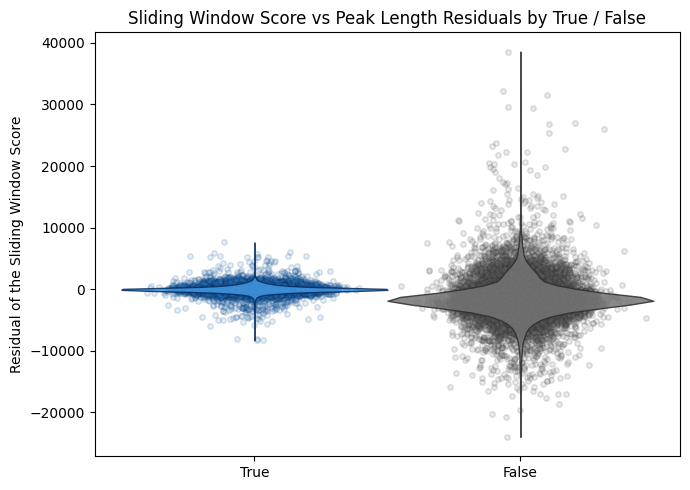

In [76]:
import numpy as np
import matplotlib.pyplot as plt

resid_col = "fit_sliding_window_score"  # your residuals

df = pos_peak_len_df.dropna(subset=["peak_length", resid_col]).copy()
true_mask = df["source_id_x"] == df["source_id_y"]

# (optional) subsample to keep plots readable
N = 20_000
true_resid  = df.loc[true_mask,  resid_col].sample(min(N, true_mask.sum()),  random_state=0).values
false_resid = df.loc[~true_mask, resid_col].sample(min(N, (~true_mask).sum()), random_state=0).values

fig, ax = plt.subplots(figsize=(7,5))

# --- Add jittered points ---
rng = np.random.default_rng(0)
jitter_scale = 0.1  # width of the horizontal jitter

x_true  = rng.normal(loc=1.0, scale=jitter_scale, size=true_resid.size)
x_false = rng.normal(loc=2.0, scale=jitter_scale, size=false_resid.size)

ax.scatter(x_true,  true_resid,  s=15, alpha=0.15, c="#4195df", edgecolors="#032b5f", rasterized=True)
ax.scatter(x_false, false_resid, s=15, alpha=0.15, c="#747474", edgecolors="#2D2D2D", rasterized=True)

parts = ax.violinplot([true_resid, false_resid],
                      positions=[1,2], widths=1,
                      showmedians=False, showextrema=False)

# Style violins to match your palette
for pc, face, edge in zip(parts['bodies'],
                          ["#4195df", "#747474"],
                          ["#032b5f", "#2D2D2D"]):
    pc.set_facecolor(face)
    pc.set_edgecolor(edge)
    pc.set_alpha(0.85)
    pc.set_linewidth(1)

ax.set_xticks([1,2]); ax.set_xticklabels(["True", "False"])
ax.set_ylabel("Residual of the Sliding Window Score")
ax.set_title("Sliding Window Score vs Peak Length Residuals by True / False")
fig.tight_layout()
plt.show()


In [ ]:
pos_peak_len_df = peak_len_df[peak_len_df["sliding_window_score"] > 0]

true_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] == pos_peak_len_df["source_id_y"]].sample(25000)
false_df = pos_peak_len_df[pos_peak_len_df["source_id_x"] != pos_peak_len_df["source_id_y"]].sample(25000)

fig = plt.figure(figsize=(8,8))
false_correlation = pearsonr(false_df["peak_length"], false_df["sliding_window_score"])
true_correlation = pearsonr(true_df["peak_length"], true_df["sliding_window_score"])

slope, intercept, r, p, stderr = linregress(true_df["peak_length"], true_df["sliding_window_score"])
line = f'Regression line: y = {slope:.2f}x + {intercept:.2f}, r={r:.2f}'

sc_false = plt.scatter(x=false_df["peak_length"], y=false_df["sliding_window_score"], s=28,  c="#747474", edgecolors="#2D2D2D", alpha=0.3)
sc_true = plt.scatter(x=true_df["peak_length"], y=true_df["sliding_window_score"], s=28, edgecolors="#032b5f",  c="#4195df")

max_x = max(max(true_df["peak_length"]), max(false_df["peak_length"])) * 0.9

plt.plot(np.arange(0, max_x), intercept + slope * np.arange(0, max_x), c="black", linewidth=2, linestyle="--", label=line)

plt.title("Sliding Window Score vs Peak Length", fontsize=16)
plt.xlabel("Peak Length (bp)", fontsize=14)
plt.ylabel("Sliding Window Score", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

  - TF Ctcf has 66081 true edges and 21371 false edges
  - TF Nrf1 has 297 true edges and 87155 false edges
  - TF Otx2 has 180 true edges and 87272 false edges
  - TF Pknox1 has 68 true edges and 87384 false edges
  - TF Prdm15 has 11 true edges and 87441 false edges
  - TF Rest has 260 true edges and 87192 false edges
  - TF Smad1 has 81 true edges and 87371 false edges
  - TF Smad3 has 112 true edges and 87340 false edges
  - TF Sox2 has 171 true edges and 87281 false edges


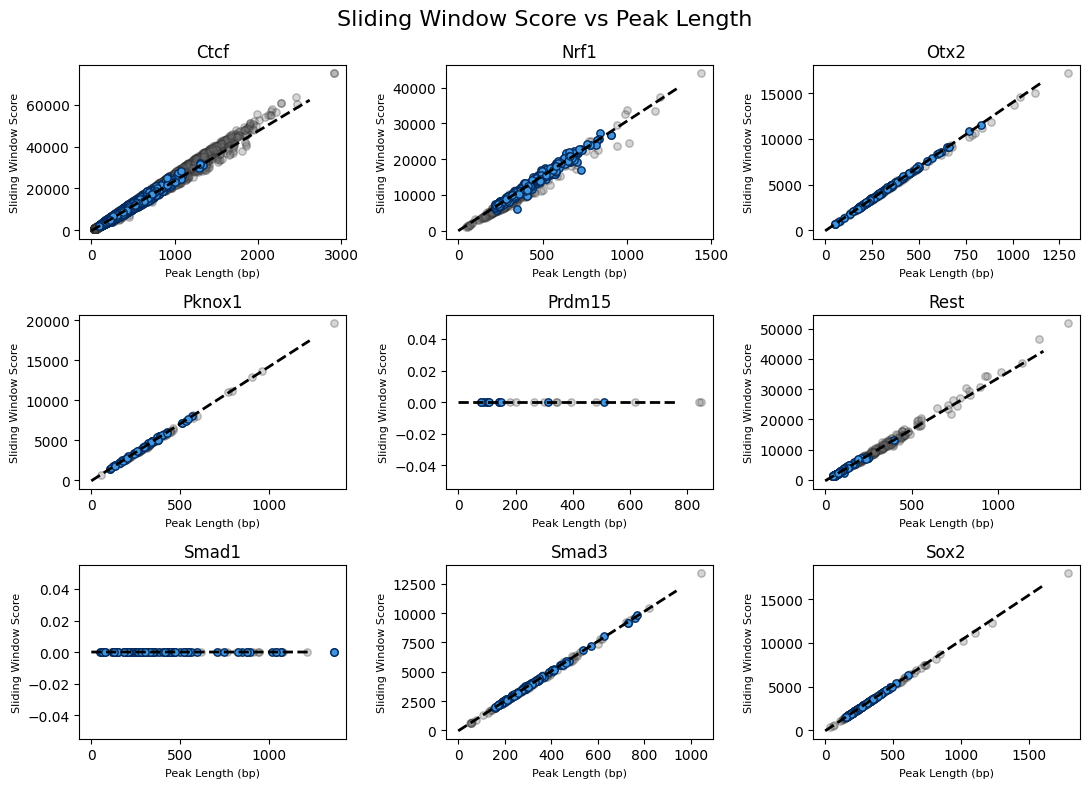

In [136]:
def plot_distance_scatter_by_tf(
    df: pd.DataFrame,
    score_col: str,
    tf_col_name: str = "source_id",
    tfs_of_interest: list[str] = [],
    title: str = "",
    limit_x: bool = False,
    top_tf_limit: int = 16,
    log: bool = False
    ):
    y_cmap = plt.get_cmap("tab20c")
    
    # if len(df) > 1e6:
    #     df = df.sample(n=1_000_000)
    
    # # TF column exists
    # assert tf_col_name in df.columns, f"ERROR: tf_col_name {tf_col_name} not in df.columns {df.columns}"
    
    # # All TFs are in the df
    # assert all(x in df[tf_col_name].to_list() for x in tfs_of_interest), \
    #     f"ERROR: Found items in tfs_of_interest not in df: {[i for i in tfs_of_interest if i not in df[tf_col_name].to_list()]}"
    
    # # Set top_tf_limit to the number of TFs if it's too high
    # if df[tf_col_name].nunique() < top_tf_limit:
    #     print(f"INFO: top_tf_limit set to {top_tf_limit}, but only {df[tf_col_name].nunique()} unique TFs in the df.\n\t- Setting top_tf_limit = {df[tf_col_name].nunique()}")
    #     top_tf_limit = df[tf_col_name].nunique()
    
    # # Use all TFs if none are specified
    # if len(tfs_of_interest) == 0:
    #     print(f"INFO: No TFs of interest specified, defaulting to the top_tf_limit ({top_tf_limit}) TFs")
    #     tfs_of_interest = df[tf_col_name].drop_duplicates().to_list()
    #     tf_rows_in_df = df[df[tf_col_name].isin(tfs_of_interest)]
    #     # df = (
    #     #     tf_rows_in_df
    #     #     .groupby(tf_col_name)
    #     #     .count()
    #     #     .sort_values(score_col, ascending=False)
    #     #     .reset_index()
    #     #     )
    #     tfs_of_interest = df[tf_col_name].drop_duplicates().to_list()

    # # Limit the number of TFs to plot
    # if len(tfs_of_interest) > top_tf_limit:
    #     tfs_of_interest = tfs_of_interest[0:top_tf_limit]
    #     print(f"INFO: Limiting to scores from the top {top_tf_limit} TFs, found {len(tfs_of_interest)}")
    #     tf_rows_in_df = df[df[tf_col_name].isin(tfs_of_interest)]
    #     # df = (
    #     #     tf_rows_in_df
    #     #     .groupby(tf_col_name)
    #     #     .count()
    #     #     .sort_values(score_col, ascending=False)
    #     #     .reset_index()
    #     #     )
    #     tfs_of_interest = df[tf_col_name].iloc[:top_tf_limit].drop_duplicates().to_list()
    
    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(11, 8))
    ax = axes.flatten()
    
    num_plots = 0
    tf_count = 0
    
    while num_plots < (rows * cols) and tf_count <= len(tfs_of_interest):
        tfs = df[df[tf_col_name] == tfs_of_interest[tf_count]]
        
        true_df = tfs[tfs["source_id_x"] == tfs["source_id_y"]]
        false_df = tfs[tfs["source_id_x"] != tfs["source_id_y"]]
        
        if len(true_df) > 10 and len(true_df) > 10:
            print(f"  - TF {tfs_of_interest[tf_count]} has {len(true_df)} true edges and {len(false_df)} false edges")

            slope, intercept, r, p, stderr = linregress(true_df["peak_length"], true_df["sliding_window_score"])
            line = f'Regression line: y = {slope:.2f}x + {intercept:.2f}, r={r:.2f}'
            
            min_value_count = min(len(true_df), len(false_df))
            true_df = true_df.sample(min_value_count)
            false_df = false_df.sample(min_value_count)

            ax[num_plots].scatter(x=false_df["peak_length"], y=false_df["sliding_window_score"], s=28,  c="#747474", edgecolors="#2D2D2D", alpha=0.3, rasterized=True)
            ax[num_plots].scatter(x=true_df["peak_length"], y=true_df["sliding_window_score"], s=28, edgecolors="#032b5f",  c="#4195df", rasterized=True)

            max_x = max(max(true_df["peak_length"]), max(false_df["peak_length"])) * 0.9

            ax[num_plots].plot(np.arange(0, max_x), intercept + slope * np.arange(0, max_x), c="black", linewidth=2, linestyle="--", label=line)

            ax[num_plots].set_title(tfs_of_interest[tf_count])
            ax[num_plots].set_xlabel("Peak Length (bp)", fontsize=8)
            ax[num_plots].set_ylabel("Sliding Window Score", fontsize=8)
            
            num_plots += 1

        tf_count += 1
    
        if tf_count == len(tfs_of_interest):
            
            num_plots = 20
            
    plt.suptitle("Sliding Window Score vs Peak Length", fontsize=16)

    if limit_x:
        plt.xlim(0, 1)

    # fig.legend(
    #     loc="lower center",
    #     ncol=1,
    #     fontsize=9,
    #     bbox_to_anchor=(1.10, 0.2),

    # )
    fig.tight_layout(rect=(0.0, 0.0, 1.0, 1.0))
    plt.show()
    
plot_distance_scatter_by_tf(
    df=peak_len_df, 
    score_col="sliding_window_score", 
    tf_col_name="source_id_x", 
    tfs_of_interest=peak_len_df["source_id_x"].unique(), 
    top_tf_limit=peak_len_df["source_id_x"].nunique()
    )

### Setting TGs as closest gene TSS, score calculations, merging with ground truth

We will use the peak-TG edges from the ChIP-Atlas tf-peak-nearest gene TSS file to map the peaks to target genes.

In [ ]:
chipseq_gene_tss_sliding_window_df = pd.merge(chipseq_sliding_window_df, chip_atlas_edges_full, on="peak_id", how="inner")
chipseq_gene_tss_sliding_window_df = chipseq_gene_tss_sliding_window_df.drop(columns="source_id_y").rename(columns={"source_id_x": "source_id"})

chipseq_gene_tss_tf_tg_sum_df = calculate_summed_tf_tg_score(chipseq_gene_tss_sliding_window_df)
chipseq_gene_tss_tf_peak_tg_df = calculate_tf_peak_tg_score(chipseq_gene_tss_sliding_window_df)

# chipseq_gene_tss_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
#     chipseq_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth,
#     method="nearest gene TSS", gt_name="RN111"
#     )

# chipseq_gene_tss_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
#     chipseq_gene_tss_tf_tg_sum_df, rn115_ko_ground_truth,
#     method="nearest gene TSS", gt_name="RN115"
#     )

chipseq_gene_tss_tf_tg_sum_chip_atlas_df = merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_tg_sum_df, chip_atlas_ground_truth,
    method="nearest gene TSS", gt_name="ChIP-Atlas"
    )

# chipseq_gene_tss_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
#     chipseq_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth,
#     method="nearest gene TSS", gt_name="RN111"
#     )

# chipseq_gene_tss_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
#     chipseq_gene_tss_tf_peak_tg_df, rn115_ko_ground_truth,
#     method="nearest gene TSS", gt_name="RN115"
#     )

chipseq_gene_tss_tf_peak_tg_chip_atlas_df = merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_peak_tg_df, chip_atlas_ground_truth,
    method="nearest gene TSS", gt_name="ChIP-Atlas"
    )

In [44]:
# chipseq_gene_tss_tf_tg_sum_rn111_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn111_df.parquet")
# chipseq_gene_tss_tf_tg_sum_rn115_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn115_df.parquet")
chipseq_gene_tss_tf_tg_sum_chip_atlas_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_chip_atlas_df.parquet")
# chipseq_gene_tss_tf_peak_tg_rn111_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn111_df.parquet")
# chipseq_gene_tss_tf_peak_tg_rn115_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn115_df.parquet")
chipseq_gene_tss_tf_peak_tg_chip_atlas_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_chip_atlas_df.parquet")

In [11]:
# chipseq_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn111_df.parquet")
# chipseq_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn115_df.parquet")
chipseq_gene_tss_tf_tg_sum_chip_atlas_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_chip_atlas_df.parquet")

# chipseq_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn111_df.parquet")
# chipseq_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn115_df.parquet")
chipseq_gene_tss_tf_peak_tg_chip_atlas_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_chip_atlas_df.parquet")

In [12]:
import grn_inference


importlib.reload(grn_inference.utils)

<module 'grn_inference.utils' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/src/grn_inference/utils.py'>

In [47]:
chipseq_gene_tss_tf_tg_sum_chip_atlas_df = grn_inference.utils.merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_tg_sum_df, chip_atlas_ground_truth,
    method="nearest gene TSS", gt_name="ChIP-Atlas", show_network_size=True
    )

chipseq_gene_tss_tf_peak_tg_chip_atlas_df = grn_inference.utils.merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_peak_tg_df, chip_atlas_ground_truth,
    method="nearest gene TSS", gt_name="ChIP-Atlas", show_network_size=True
    )

- **Overlap between nearest gene TSS and ChIP-Atlas edges**
	- **Both ChIP-Atlas and nearest gene TSS**
		- TFs: 87
		- TGs: 11,288
		- TF-TG Edges: 279,619
	- **Only Nearest gene tss**
		- TFs: 0
		- TGs: 0
		- TF-TG Edges: 702,524
	- **Only ChIP-Atlas**
		- TFs: 44
		- TGs: 13,532
		- Edges: 0
- **Overlap between nearest gene TSS and ChIP-Atlas edges**
	- **Both ChIP-Atlas and nearest gene TSS**
		- TFs: 87
		- TGs: 11,288
		- TF-TG Edges: 279,619
	- **Only Nearest gene tss**
		- TFs: 0
		- TGs: 0
		- TF-TG Edges: 702,524
	- **Only ChIP-Atlas**
		- TFs: 44
		- TGs: 13,532
		- Edges: 0


In [51]:
importlib.reload(dev_plots)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


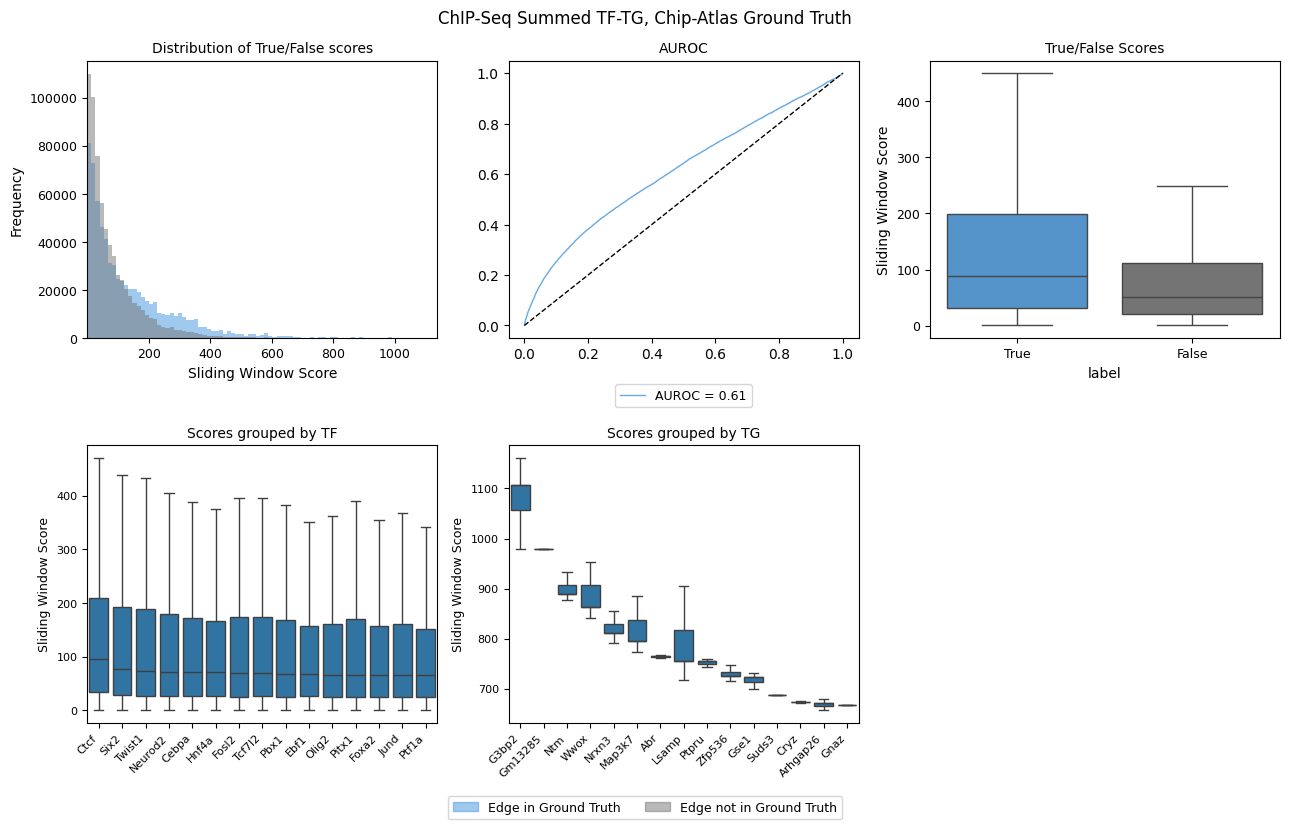

In [49]:
import matplotlib.patches as mpatches
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(13, 8))

chipseq_plot_df = chipseq_gene_tss_tf_tg_sum_chip_atlas_df

dev_plots.plot_scores_distribution(chipseq_plot_df,
                        title="Distribution of True/False scores",
                        ax=axes[0, 0])

dev_plots.plot_grouped_score_boxplot(
    chipseq_plot_df,
    group_col="source_id",
    score_col="sliding_window_score",
    title=f"Scores grouped by TF",
    ylabel="Sliding Window Score",
    n_top_groups=15,
    ax=axes[1, 0]
    )

dev_plots.plot_grouped_score_boxplot(
    chipseq_plot_df,
    group_col="target_id",
    score_col="sliding_window_score",
    title=f"Scores grouped by TG",
    ylabel="Sliding Window Score",
    n_top_groups=15,
    ax=axes[1, 1]
    )


dev_plots.plot_auroc(chipseq_plot_df,
                    score_col="sliding_window_score",
                    title="AUROC",
                    ax=axes[0, 1])

dev_plots.plot_true_false_boxplots(chipseq_plot_df,
                                   ax=axes[0, 2])

fig.delaxes(axes[1, 2])

legend_handles = [
    mpatches.Patch(color="#4195df", alpha=0.5, label="Edge in Ground Truth"),
    mpatches.Patch(color="#747474", alpha=0.5, label="Edge not in Ground Truth")
]
fig.legend(handles=legend_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.04),  # centered below plots
        ncol=2,
        fontsize=9)

plt.suptitle("ChIP-Seq Summed TF-TG, Chip-Atlas Ground Truth")

plt.tight_layout()

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:408: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


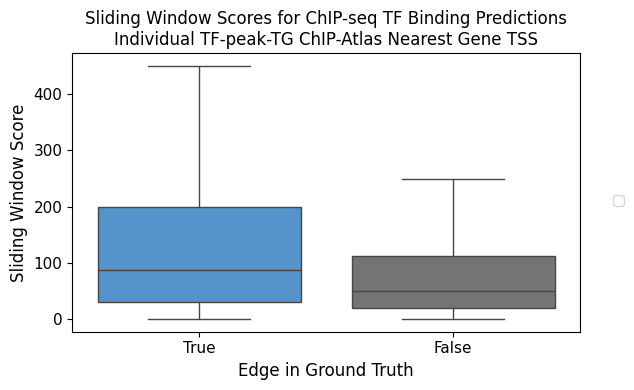

In [50]:
fig = dev_plots.plot_true_false_boxplots(
    df=chipseq_plot_df,
    xlabel="Edge in Ground Truth",
    title="Sliding Window Scores for ChIP-seq TF Binding Predictions\nIndividual TF-peak-TG ChIP-Atlas Nearest Gene TSS"
)
fig.show()

---

## Investivating DS011 Cicero-TG Summation Method Sliding Window Score Distribution

In [ ]:
import numpy as np
mesc_cicero_tf_tg_sum_rn111_df["final_score_no_scaling"] = mesc_cicero_tf_tg_sum_rn111_df["tf_to_tg_peak_scores_summed"].astype(np.float64) / ds011_cicero_tf_tg_sum_rn111_df["total_tf_score"].astype(np.float64)

In [ ]:
ds011_cicero_tf_tg_sum_rn111_df

,source_id,target_id,tf_to_tg_peak_scores_summed,total_tf_score,sliding_window_score,label,final_score_no_scaling
0,Arid3a,0610030e20rik,12934.145419,1.186995e+08,108.965488,False,0.000109
1,Arid3a,0610039k10rik,25626.523497,1.186995e+08,215.894174,False,0.000216
2,Arid3a,0610040j01rik,12922.940587,1.186995e+08,108.871091,False,0.000109
3,Arid3a,1700020a23rik,13835.680367,1.186995e+08,116.560593,False,0.000117
4,Arid3a,1700034e13rik,13933.383886,1.186995e+08,117.383710,False,0.000117
...,...,...,...,...,...,...,...
146320,Zic3,Zp2,23557.565885,2.067197e+08,113.958956,False,0.000114
146321,Zic3,Zranb1,23760.721379,2.067197e+08,114.941715,False,0.000115
146322,Zic3,Zscan20,22268.398221,2.067197e+08,107.722650,False,0.000108
146323,Zic3,Zscan25,87160.728749,2.067197e+08,421.637182,False,0.000422


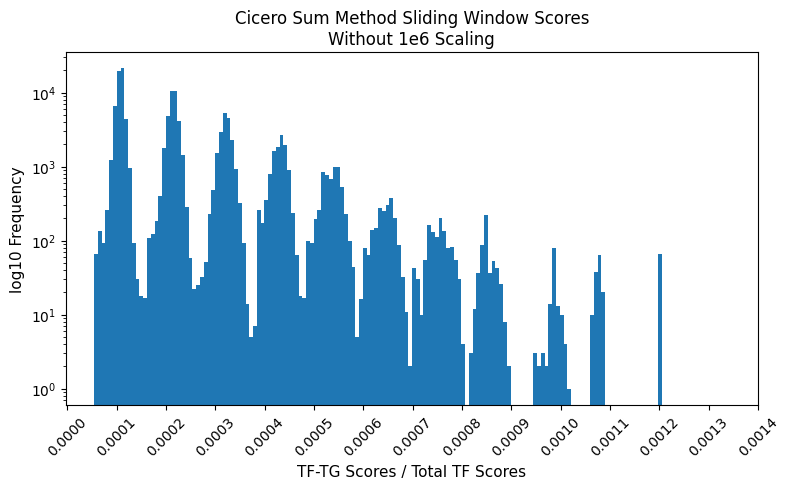

In [ ]:

mask = mesc_cicero_tf_tg_sum_rn111_df["final_score_no_scaling"] > 0.0009

plt.figure(figsize=(8, 5))
plt.hist(ds011_cicero_tf_tg_sum_rn111_df["final_score_no_scaling"], bins=150, log=True)
labels = np.arange(0, 0.0015, 0.0001)
plt.xticks(labels, rotation=45)
plt.title("Cicero Sum Method Sliding Window Scores\nWithout 1e6 Scaling", fontsize=12)
plt.ylabel("log10 Frequency", fontsize=11)
plt.xlabel("TF-TG Scores / Total TF Scores", fontsize=11)
plt.tight_layout()
plt.show()

Let's look at the distributions that are used to calculate the final sliding window score for the TF-TG peak score summation method. We take the sum of peaks for each unique TF-TG edge and divide it by the sum of all sliding window scores for the TF.

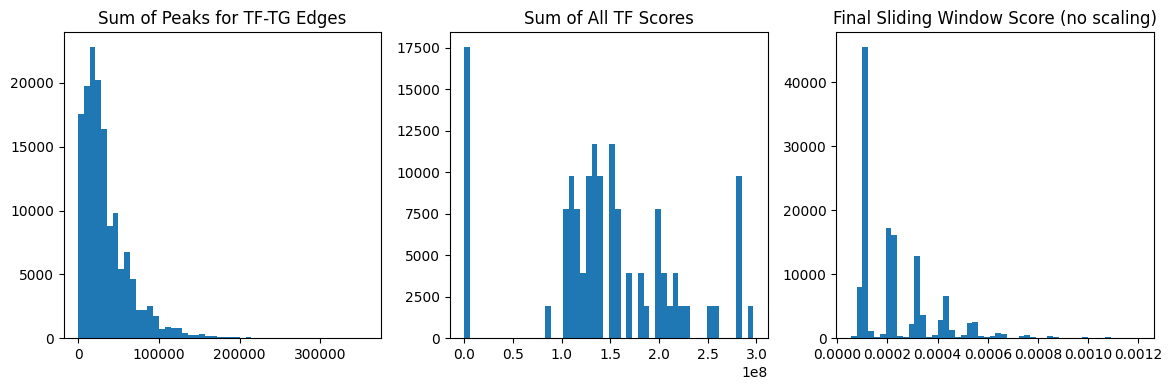

In [ ]:
cols_of_interest = ["tf_to_tg_peak_scores_summed", "total_tf_score", "final_score_no_scaling"]
col_titles = ["Sum of Peaks for TF-TG Edges", "Sum of All TF Scores", "Final Sliding Window Score (no scaling)"]

fig, ax = plt.subplots(1, 3, figsize=(12,4))
for i, ax in enumerate(ax.flat):
    ax.hist(
        ds011_cicero_tf_tg_sum_rn111_df[cols_of_interest[i]],
        bins=50
    )
    ax.set_title(col_titles[i])

plt.tight_layout()
plt.show()

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:501: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


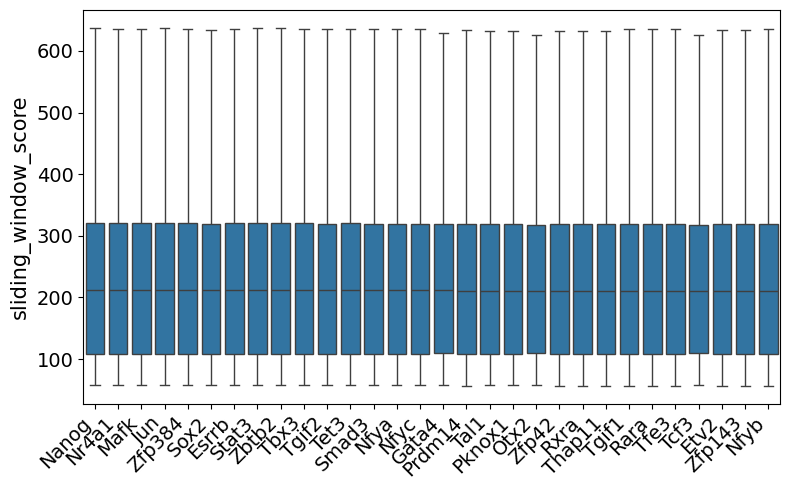

In [ ]:
fig = dev_plots.plot_grouped_score_boxplot(
    df=ds011_cicero_tf_tg_sum_rn111_df,
    group_col="source_id",
    score_col="sliding_window_score",
    n_top_groups=30,
)
fig.show()

In [ ]:
group_by_total_tf_score = (
    ds011_gene_tss_tf_tg_sum_rn111_df[["source_id", "total_tf_score"]]
    .drop_duplicates()
    .set_index("source_id")
    )
group_by_total_tf_score

,total_tf_score
source_id,
Arid3a,2.428686e+09
Ascl1,3.420851e+09
Cdx2,2.275302e+09
Ctcf,3.699613e+09
Ctcfl,4.581302e+09
...,...
Zfp42,2.986780e+09
Zfp57,2.457963e+09
Zfx,5.237529e+09


In [ ]:
grouped_by_tf = (
    ds011_gene_tss_tf_tg_sum_rn111_df
    .groupby("source_id")
    .count()
    .sort_values("total_tf_score", ascending=False)
    ).rename(columns={"target_id":"num_targets"})[["num_targets"]]
grouped_by_tf["total_tf_score"] = grouped_by_tf.index.map(group_by_total_tf_score.squeeze())
grouped_by_tf = grouped_by_tf.sort_values(by="total_tf_score", ascending=False)
max_total_tf_score = max(group_by_total_tf_score["total_tf_score"])
grouped_by_tf["total_tf_score"] = grouped_by_tf["total_tf_score"].apply(lambda x: x / max_total_tf_score)

grouped_by_tf

,num_targets,total_tf_score
source_id,,
Rxra,14728,1.000000
Thap11,14728,0.959771
Zfp143,14728,0.952541
Zfp322a,14728,0.941669
Rest,14728,0.933119
...,...,...
Pou5f1,14728,0.000000
Smad1,14728,0.000000
Setdb1,14728,0.000000


In [ ]:
grouped_by_tg = (
    ds011_gene_tss_tf_tg_sum_rn111_df
    .groupby("target_id")
    .mean(numeric_only=True)
    .sort_values("tf_to_tg_peak_scores_summed", ascending=False)
    ).rename(columns={"tf_to_tg_peak_scores_summed":"mean_tf_to_tg_peak_score"})[["mean_tf_to_tg_peak_score"]]
grouped_by_tg = grouped_by_tg.sort_values(by="mean_tf_to_tg_peak_score", ascending=False)
max_total_tg_score = max(grouped_by_tg["mean_tf_to_tg_peak_score"])
grouped_by_tg["scaled_avg_target_score"] = grouped_by_tg["mean_tf_to_tg_peak_score"].apply(lambda x: x / max_total_tg_score)


grouped_by_tg

,mean_tf_to_tg_peak_score,scaled_avg_target_score
target_id,,
Pde4d,2.481309e+06,1.000000
Rbfox1,2.337633e+06,0.942097
Slit3,1.805125e+06,0.727489
Cdh13,1.782315e+06,0.718296
Auts2,1.734862e+06,0.699172
...,...,...
Rab35,6.620836e+03,0.002668
Trim10,6.256636e+03,0.002522
Taf12,5.719402e+03,0.002305


In [ ]:
first_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 60) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 120)
][["source_id", "target_id", "sliding_window_score"]]

second_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 180) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 240)
][["source_id", "target_id", "sliding_window_score"]]

third_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 300) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 360)
][["source_id", "target_id", "sliding_window_score"]]

fourth_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 420) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 480)
][["source_id", "target_id", "sliding_window_score"]]



In [ ]:
first_peak_unique_tfs = first_peak_df[
    (~first_peak_df["source_id"].isin(second_peak_df["source_id"])) &
    (~first_peak_df["source_id"].isin(third_peak_df["source_id"])) &
    (~first_peak_df["source_id"].isin(fourth_peak_df["source_id"]))
    ]
print(f"{len(first_peak_unique_tfs)} / {first_peak_df['source_id'].nunique()} TFs only in the first peak")

second_peak_unique_tfs = second_peak_df[
    (~second_peak_df["source_id"].isin(first_peak_df["source_id"])) &
    (~second_peak_df["source_id"].isin(third_peak_df["source_id"])) &
    (~second_peak_df["source_id"].isin(fourth_peak_df["source_id"]))
    ]
print(f"{len(second_peak_unique_tfs)} / {second_peak_df['source_id'].nunique()} TFs only in the second peak")

third_peak_unique_tfs = third_peak_df[
    (~third_peak_df["source_id"].isin(first_peak_df["source_id"])) &
    (~third_peak_df["source_id"].isin(second_peak_df["source_id"])) &
    (~third_peak_df["source_id"].isin(fourth_peak_df["source_id"]))
    ]
print(f"{len(third_peak_unique_tfs)} / {third_peak_df['source_id'].nunique()} TFs only in the third peak")

fourth_peak_unique_tfs = fourth_peak_df[
    (~fourth_peak_df["source_id"].isin(first_peak_df["source_id"])) &
    (~fourth_peak_df["source_id"].isin(second_peak_df["source_id"])) &
    (~fourth_peak_df["source_id"].isin(third_peak_df["source_id"]))
    ]
print(f"{len(fourth_peak_unique_tfs)} / {fourth_peak_df['source_id'].nunique()} TFs only in the third peak")

0 / 66 TFs only in the first peak
0 / 66 TFs only in the second peak
0 / 66 TFs only in the third peak
0 / 66 TFs only in the third peak


In [ ]:
first_peak_unique_tgs = first_peak_df[
    (~first_peak_df["target_id"].isin(second_peak_df["target_id"])) &
    (~first_peak_df["target_id"].isin(third_peak_df["target_id"])) &
    (~first_peak_df["target_id"].isin(fourth_peak_df["target_id"]))
    ]
print(f"{len(first_peak_unique_tgs)} / {len(first_peak_df)} TGs only in the first peak")

second_peak_unique_tgs = second_peak_df[
    (~second_peak_df["target_id"].isin(first_peak_df["target_id"])) &
    (~second_peak_df["target_id"].isin(third_peak_df["target_id"])) &
    (~second_peak_df["target_id"].isin(fourth_peak_df["target_id"]))
    ]
print(f"{len(second_peak_unique_tgs)} / {len(second_peak_df)} TGs only in the second peak")

third_peak_unique_tgs = third_peak_df[
    (~third_peak_df["target_id"].isin(first_peak_df["target_id"])) &
    (~third_peak_df["target_id"].isin(second_peak_df["target_id"])) &
    (~third_peak_df["target_id"].isin(fourth_peak_df["target_id"]))
    ]
print(f"{len(third_peak_unique_tgs)} / {len(third_peak_df)} TGs only in the third peak")

fourth_peak_unique_tgs = fourth_peak_df[
    (~fourth_peak_df["target_id"].isin(first_peak_df["target_id"])) &
    (~fourth_peak_df["target_id"].isin(second_peak_df["target_id"])) &
    (~fourth_peak_df["target_id"].isin(third_peak_df["target_id"]))
    ]
print(f"{len(fourth_peak_unique_tgs)} / {len(fourth_peak_df)} TGs only in the third peak")

146265 / 146265 TGs only in the first peak
15217 / 15217 TGs only in the second peak
3285 / 3285 TGs only in the third peak
1189 / 1189 TGs only in the third peak


Sum of all sliding window scores for each TF, grouped by TF

INFO: Limiting to scores from the top 40 TFs, found 40


100%|██████████| 40/40 [00:06<00:00,  5.93it/s]                                                                                                                                                                                      


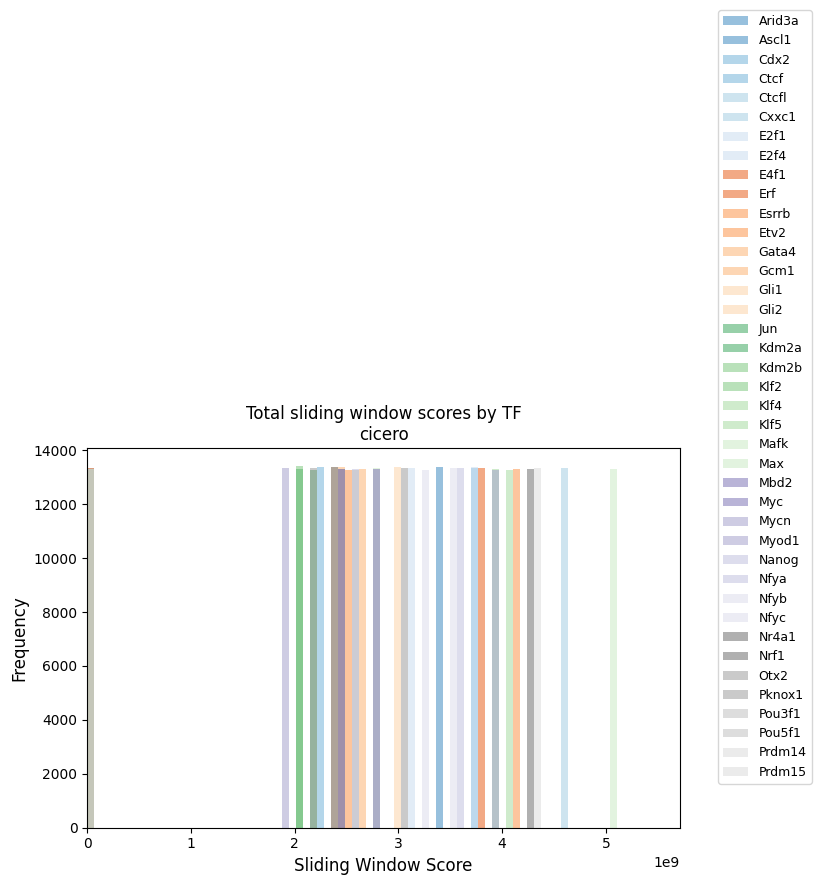

In [ ]:
importlib.reload(dev_plots)

df = (
    ds011_gene_tss_tf_tg_sum_rn111_df
    .groupby("source_id")
    .count()
    .sort_values("total_tf_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["source_id"].drop_duplicates().to_list()

num_tfs = 40

dev_plots.plot_score_distribution_by_tf(
    df=ds011_gene_tss_tf_tg_sum_rn111_df, 
    score_col="total_tf_score", 
    title="Total sliding window scores by TF\ncicero",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )

Sum of all sliding window scores for each TF, grouped by TG

Sum of sliding window scores for multiple TF-TG peaks, grouped by TF

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:00<00:00, 20.42it/s]                                                                                                                                                                                      


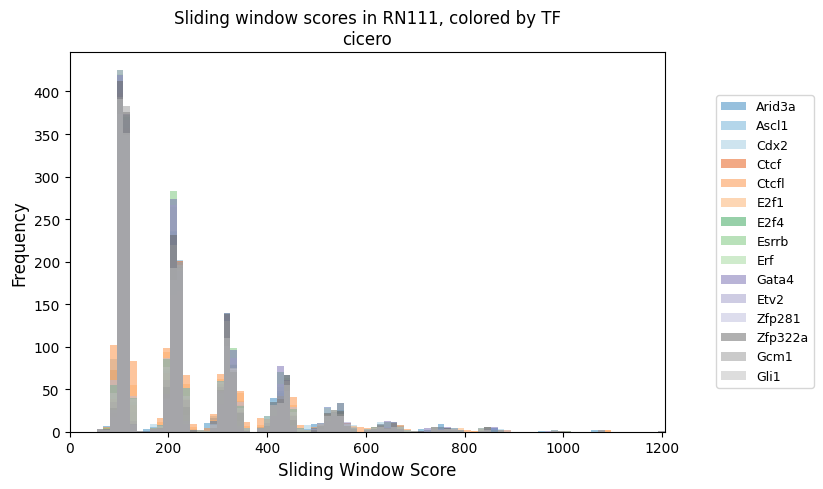

In [ ]:
importlib.reload(dev_plots)

df = (
    ds011_cicero_tf_tg_sum_rn111_df
    .groupby("source_id")
    .count()
    .sort_values("sliding_window_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["source_id"].drop_duplicates().to_list()

num_tfs = 15

dev_plots.plot_score_distribution_by_tf(
    df=ds011_cicero_tf_tg_sum_rn111_df, 
    score_col="sliding_window_score", 
    title="Sliding window scores in RN111, colored by TF\ncicero",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:00<00:00, 25.73it/s]                                                                                                                                                                                      


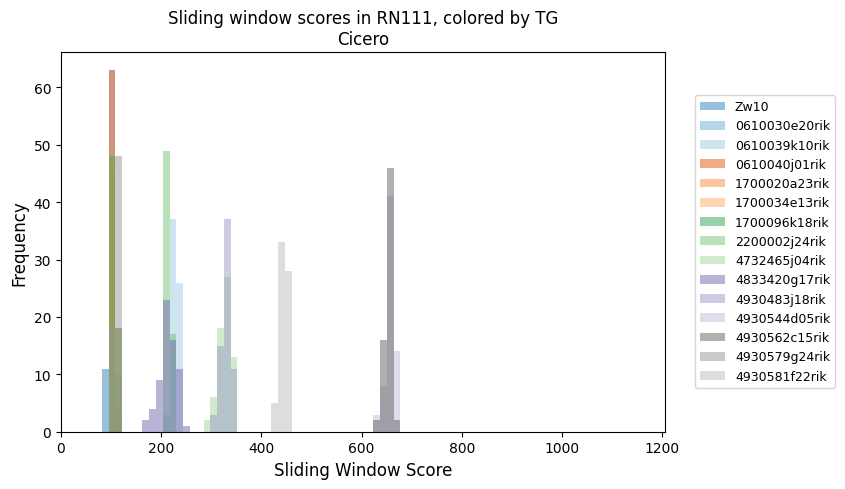

In [ ]:
importlib.reload(dev_plots)

df = (
    ds011_cicero_tf_tg_sum_rn111_df
    .groupby("target_id")
    .count()
    .sort_values("sliding_window_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["target_id"].drop_duplicates().to_list()

num_tfs = 15

dev_plots.plot_score_distribution_by_tf(
    df=ds011_cicero_tf_tg_sum_rn111_df, 
    score_col="sliding_window_score", 
    tf_col_name="target_id",
    title="Sliding window scores in RN111, colored by TG\nCicero",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )

It looks like the sliding window scores are mainly grouping by TG rather than TF. We can see how tight the sliding window score distributions are around each TG to get a better sense of what's going on. If the score distributions are tight for individual TGs but the score distributions are different *between* TGs, this would explain the spikey distribution in the sliding window scores.

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:501: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


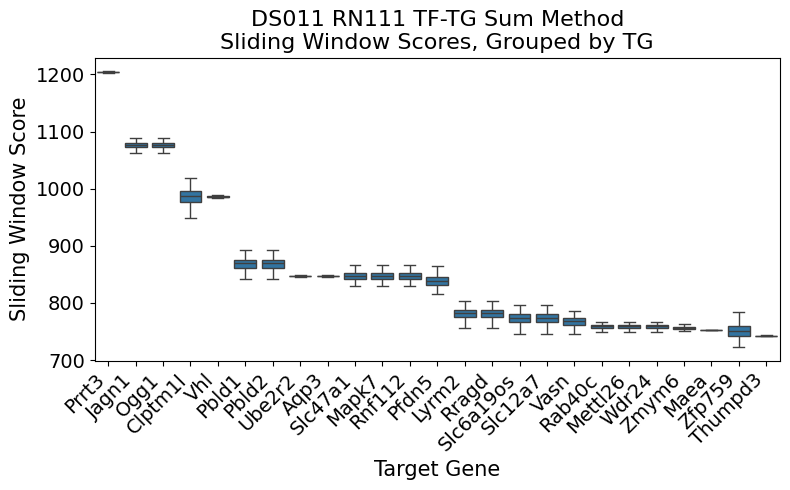

In [ ]:
fig = dev_plots.plot_grouped_score_boxplot(
    df=ds011_cicero_tf_tg_sum_rn111_df,
    group_col="target_id",
    score_col="sliding_window_score",
    title="DS011 RN111 TF-TG Sum Method\nSliding Window Scores, Grouped by TG",
    xlabel="Target Gene",
    ylabel="Sliding Window Score",
    n_top_groups=25,
)
fig.show()

This shows what's going on. The sliding window score distributions are tight for each TG, and different between TGs. This is interesting, it's likely due to the number of sliding window scores per TG. I bet that each discrete level of scores with similar TG distributions represent a different number of peaks. When we add up the sliding window scores across all peaks, TGs with more than one peak will have a greater score.

---

# Checking if the sliding window scores for individual TFs and TGs are different between True / False scores

### Calculating Difference between True / False Score Distribution Means

In [12]:
from scipy import stats

We need to calculate the difference between the True and False sliding window score means for each TF. We will use Welch's t to calculate if the differences are significant.

$$z = \frac{ (\bar{X}_{\text{True}} - \bar{X}_{\text{False}}) }{ \sqrt{ \frac{s_{\text{True}}^{2}}{n_{\text{True}}} + \frac{s_{\text{False}}^{2}}{n_{\text{False}}} }}$$

$$df = \frac{ ( \frac{s^{2}_{\text{True}}}{n_{\text{True}}} + \frac{s^{2}_{\text{False}}}{n_{\text{False}}} )^{2} }{ \frac{ (s^{2}_{\text{True}}/n_{True})^{2} }{n_{\text{True}}-1} + \frac{ (s^{2}_{\text{False}}/n_{\text{False}})^{2} }{n_{\text{False}}-1} }$$

First, we need to log1p normalize the sliding window scores to get them into roughly normal distributions and calculate the mean, std, and count of True / False sliding window scores by TF.

In [13]:
def calculate_difference_between_true_false_scores(df: pd.DataFrame, group_col: str) -> pd.DataFrame:
    # Calculate the mean, stdev, and count of sliding window scores for each TF
    df = df.copy()
    df_grouped = (
        df[["source_id", "target_id", "sliding_window_score", "label"]]
        .groupby([group_col, "label"])
        .agg(
            mean=("sliding_window_score", "mean"),
            stdev=("sliding_window_score", "std"), # Guards against taking the stderr of mean when only 1 score
            count=("sliding_window_score", "size")
            )
        .reset_index()
        .dropna()
    )

    # Separate the scores by label
    pivot_df = pd.pivot(
        data=df_grouped, 
        index=group_col, 
        columns="label", 
        values=["mean", "stdev", "count"],
        ).reset_index()

    # Flatten columns to strings (rather than multi index)
    pivot_df.columns = [
        f"{col1}_{col2}" if col2 != "" else str(col1)
        for col1, col2 in pivot_df.columns
    ]

    # Welch's t
    se_diff = np.sqrt((pivot_df["stdev_True"]**2)/pivot_df["count_True"] + (pivot_df["stdev_False"]**2)/pivot_df["count_False"])
    t_stat = (pivot_df["mean_True"] - pivot_df["mean_False"]) / se_diff

    # Welch-Satterthwaite df
    df_numerator = ((pivot_df["stdev_True"]**2)/pivot_df["count_True"] + (pivot_df["stdev_False"]**2)/pivot_df["count_False"])**2
    df_denominator = ((pivot_df["stdev_True"]**2)/pivot_df["count_True"])**2 / (pivot_df["count_True"]-1) + ((pivot_df["stdev_False"]**2)/pivot_df["count_False"])**2 / (pivot_df["count_False"]-1)

    df = df_numerator / df_denominator

    # two-tailed p-values
    p_val = 2 * stats.t.sf(np.abs(t_stat), df)

    pivot_df["t_stat"] = t_stat
    pivot_df["df"] = df
    pivot_df["p_value"] = p_val
    pivot_df["significant"] = p_val < 0.05

    # Sort by significance
    pivot_df = pivot_df.sort_values(by="p_value", ascending=True)
    
    pivot_df = pivot_df.dropna()
    
    return pivot_df

### mESC True / False score Distribution Difference

In [ ]:
norm_mesc_gene_tss_tf_tg_sum_rn111_df = mesc_gene_tss_tf_tg_sum_rn111_df.copy()
norm_mesc_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] = np.log1p(mesc_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"])

mesc_tf_mean_diff_df = calculate_difference_between_true_false_scores(norm_mesc_gene_tss_tf_tg_sum_rn111_df, group_col="source_id")
mesc_tg_mean_diff_df = calculate_difference_between_true_false_scores(norm_mesc_gene_tss_tf_tg_sum_rn111_df, group_col="target_id")


#### Plotting differences between True / False Means by TF

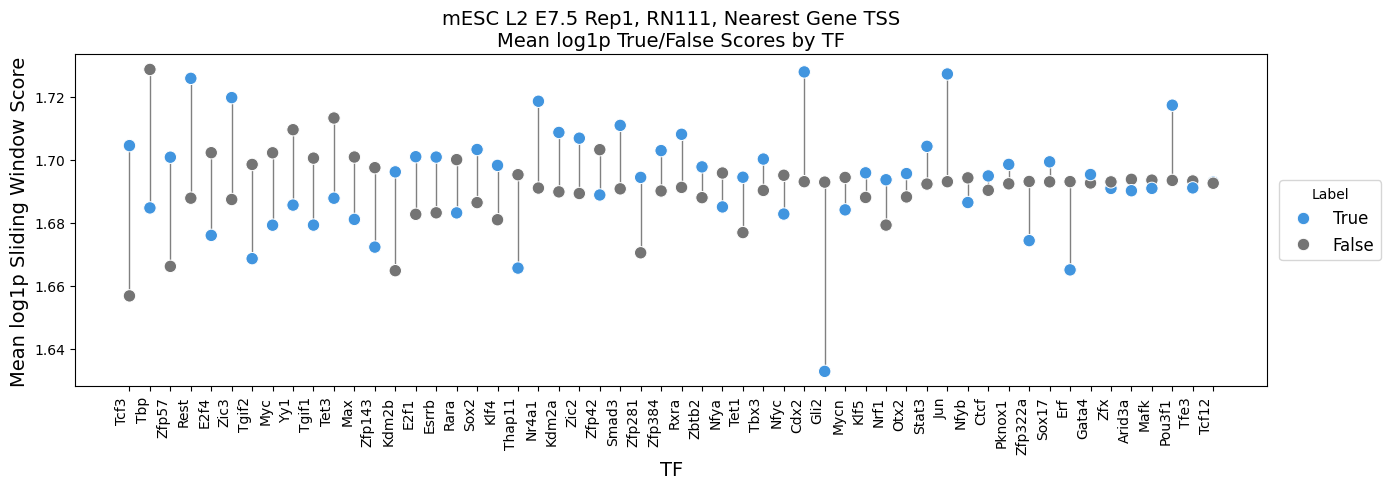

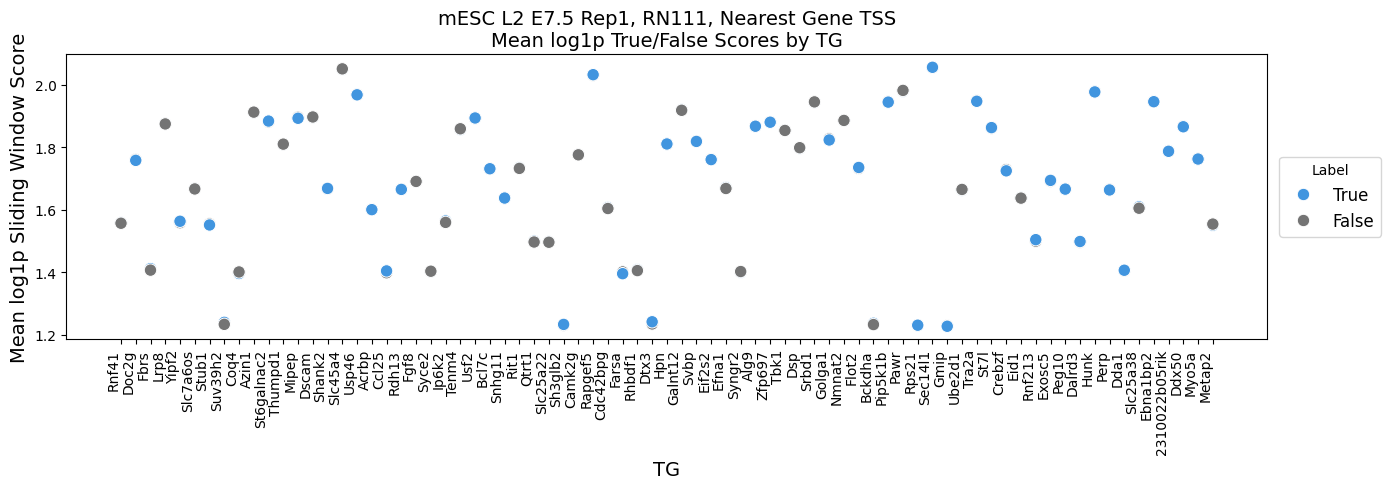

In [ ]:
mesc_tf_fig = dev_plots.plot_mean_score_differences_grouped(
    df=mesc_tf_mean_diff_df, 
    group_col="source_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
mesc_tf_fig.show()

mesc_tg_fig = dev_plots.plot_mean_score_differences_grouped(
    df=mesc_tg_mean_diff_df, 
    group_col="target_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS",
    )
mesc_tg_fig.show()

#### Plotting True / False Score Distributions by TF and TG

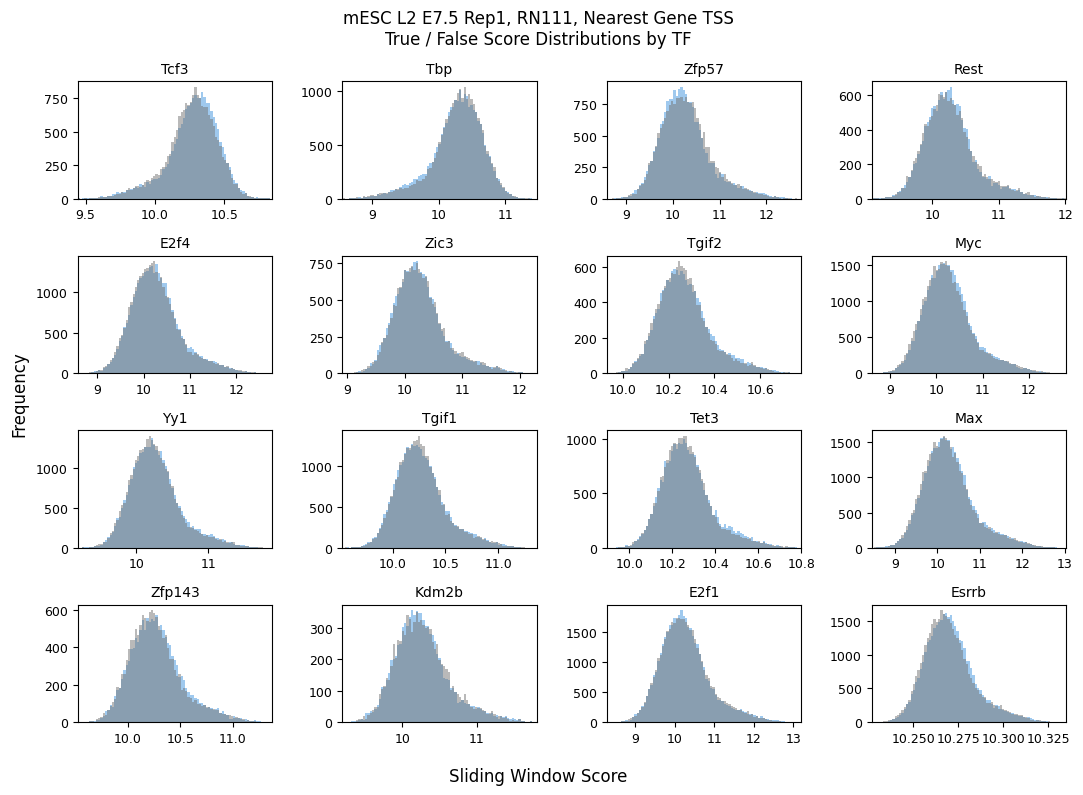

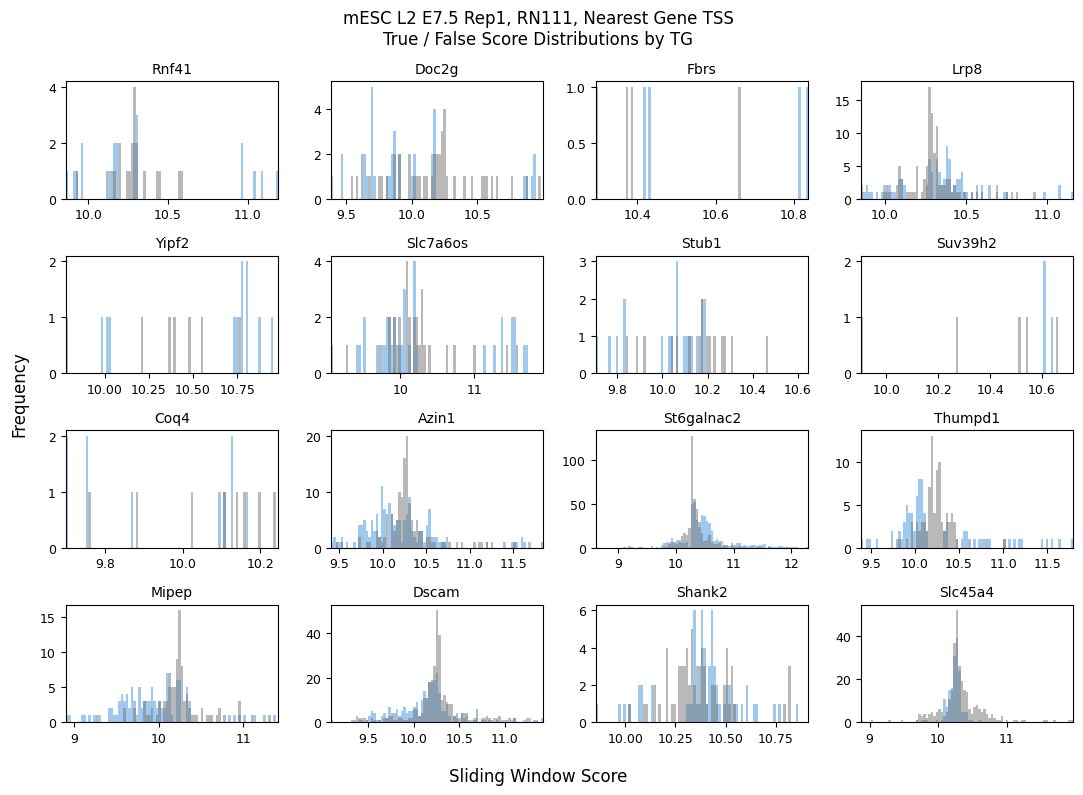

In [ ]:
tf_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=mesc_tf_mean_diff_df, 
    original_score_df=mesc_gene_tss_tf_peak_tg_rn111_df,
    group_col="source_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
tf_fig.show()

tg_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=mesc_tg_mean_diff_df, 
    original_score_df=mesc_gene_tss_tf_peak_tg_rn111_df,
    group_col="target_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
tg_fig.show()

#### Plotting Sliding Window Score vs Number of Peaks per TG

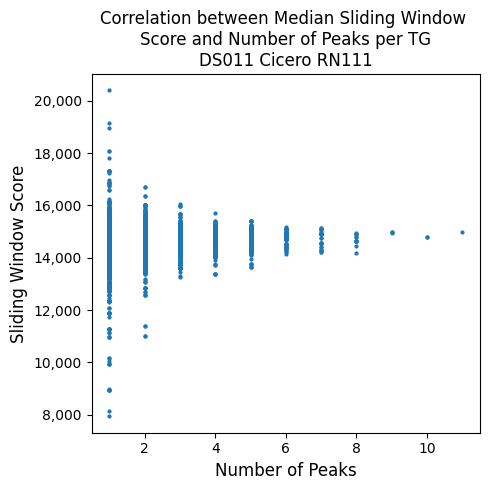

In [ ]:
import matplotlib.ticker


edges_per_tg = (
    ds011_cicero_sliding_window_df
    .groupby("target_id")
    .agg(
        peak_count=("peak_id", "nunique"),
        median_score=("sliding_window_score", "median")
    )
    .reset_index()
    .sort_values(by="peak_count", ascending=False)
)

correlation = np.corrcoef(edges_per_tg["peak_count"], edges_per_tg["median_score"])

plt.figure(figsize=(5,5))
plt.scatter(x=edges_per_tg["peak_count"], y=edges_per_tg["median_score"], s=4),
plt.title("Correlation between Median Sliding Window \nScore and Number of Peaks per TG\nDS011 Cicero RN111", fontsize=12)
plt.xlabel("Number of Peaks", fontsize=12)
plt.ylabel("Sliding Window Score", fontsize=12)

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

### ChIP-seq True / False Score Distribution Difference

I am interested in seeing if there is a relationship between the peak-nearest gene TSS distance and the True / False label. Here, we are going to look at how the True and False TF-peak scores group by distance to the nearest TG.

In [ ]:
from rustworkx import dfs_edges
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

def find_matches_for_missing_peak_to_tg_distance_values(df):
    df = df.copy()

    # Create a mapping of known peak_id to nearest gene TSS distance
    non_nan_distances = (
        df
        .dropna(subset=["distance"])
        .drop_duplicates("peak_id")
        .set_index("peak_id")["distance"]
    )

    # Map the distances with values to any missing distance values by shared peak_id
    df["distance"] = df["distance"].fillna(df["peak_id"].map(non_nan_distances))
    
    return df

df = find_matches_for_missing_peak_to_tg_distance_values(chipseq_gene_tss_tf_peak_tg_chip_atlas_df)
df


,source_id,peak_id,target_id,sliding_window_score,distance,label
0,Ascl1,chr11:51681644-51681969,0610009b22rik,10.020794,6758.0,False
1,Ascl1,chr11:51703641-51704009,0610009b22rik,11.720600,6758.0,False
2,Ascl1,chr11:51681610-51681955,0610009b22rik,10.549539,6758.0,False
3,Ascl1,chr11:51703742-51703923,0610009b22rik,5.674271,6758.0,False
4,Ascl1,chr11:51681637-51681899,0610009b22rik,8.044293,6758.0,False
...,...,...,...,...,...,...
48820337,Zfp335,chr3:152430269-152430549,Zzz3,8.355345,15812.0,False
48820338,Zfp335,chr3:152395633-152397067,Zzz3,52.047871,15812.0,False
48820339,Zfp335,chr3:152395633-152397067,Zzz3,52.047871,15812.0,False
48820340,Zfp335,chr3:152474663-152474957,Zzz3,9.239347,15812.0,False


/tmp/ipykernel_544875/2462786214.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


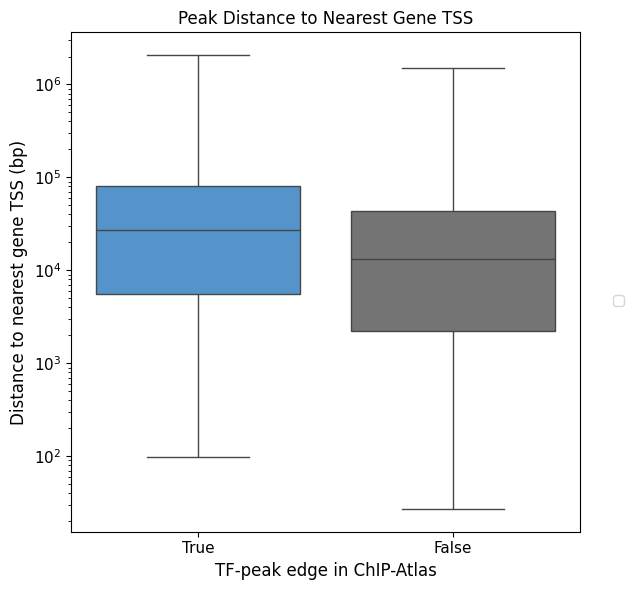

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
fontsize = 12
use_legend = True

sns.boxplot(
    data=df, 
    x="label", 
    y="distance", 
    hue="label", 
    order=["True", "False"],
    palette={
        True:"#4195df",
        False:"#747474"
        },
    legend=False, 
    showfliers=False,
    log_scale=True,
    ax=ax
    )

ax.set_ylabel("Sliding Window Score", fontsize=9)
ax.set_title("True/False Scores", fontsize=10)

ax.set_title("Peak Distance to Nearest Gene TSS", fontsize=fontsize)
ax.set_xlabel("TF-peak edge in ChIP-Atlas", fontsize=fontsize)
ax.set_ylabel("Distance to nearest gene TSS (bp)", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize-1)
ax.tick_params(axis='y', labelsize=fontsize-1)

fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)
    
fig.tight_layout()


In [56]:
norm_df = chipseq_gene_tss_tf_peak_tg_chip_atlas_df.copy()
ground_truth_name = "ChIP-Atlas"
norm_df["sliding_window_score"] = np.log1p(norm_df["sliding_window_score"])

chipseq_tf_mean_diff_df = calculate_difference_between_true_false_scores(norm_df, group_col="source_id")

chipseq_tg_mean_diff_df = calculate_difference_between_true_false_scores(norm_df, group_col="target_id")

#### Plotting differences between True / False Means by TF

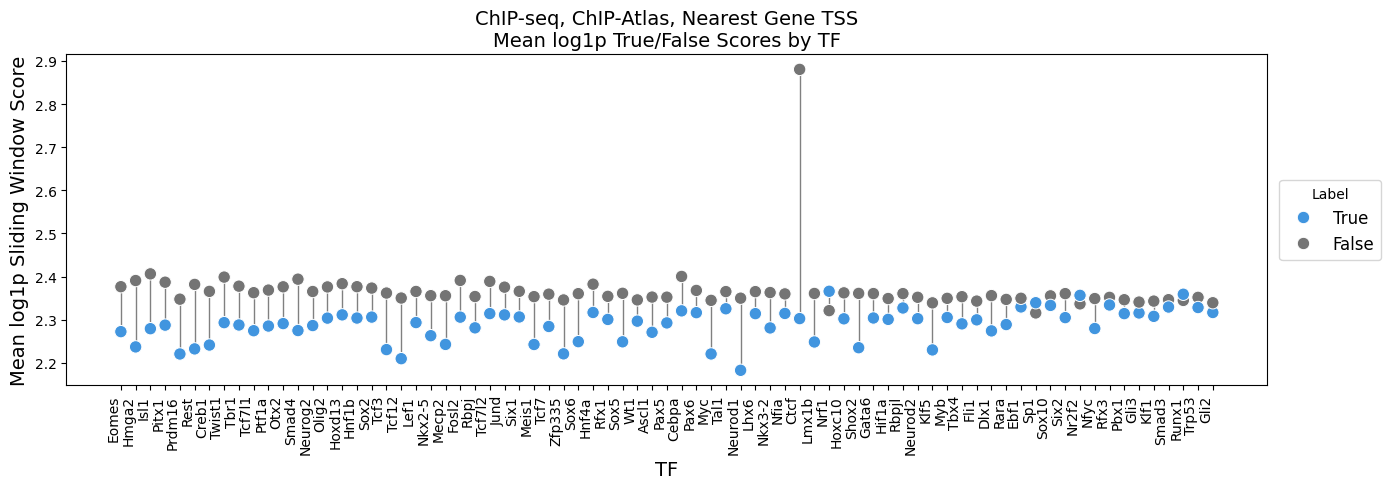

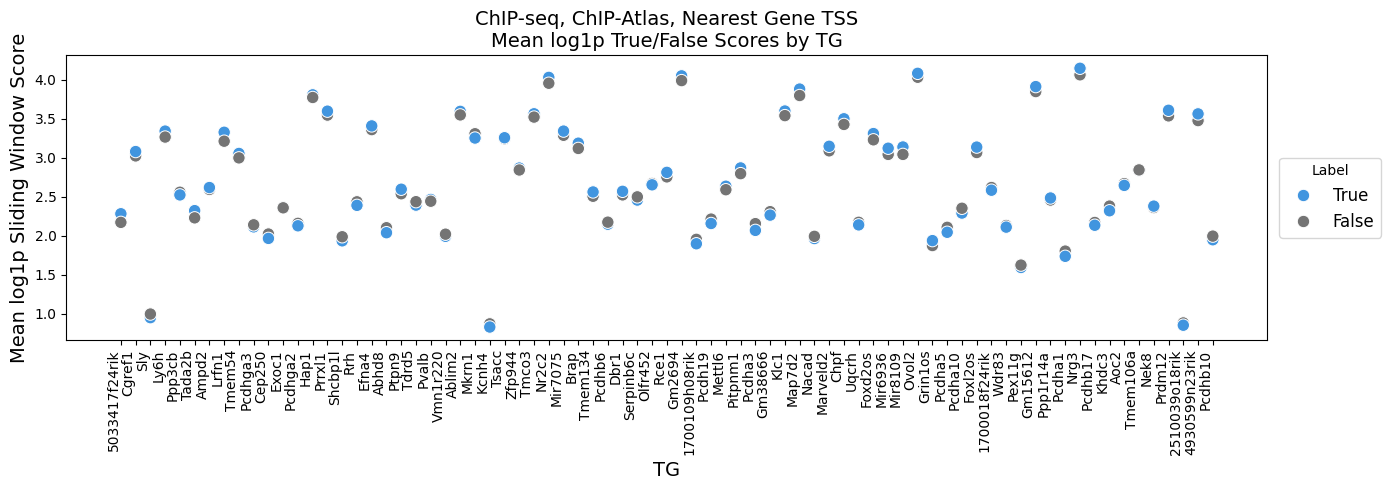

In [57]:
chipseq_tf_fig = dev_plots.plot_mean_score_differences_grouped(
    df=chipseq_tf_mean_diff_df, 
    group_col="source_id",
    sample_name="ChIP-seq",
    ground_truth_name=ground_truth_name,
    tg_label_name="Nearest Gene TSS"
    )
chipseq_tf_fig.show()

chipseq_tg_fig = dev_plots.plot_mean_score_differences_grouped(
    df=chipseq_tg_mean_diff_df, 
    group_col="target_id",
    sample_name="ChIP-seq",
    ground_truth_name=ground_truth_name,
    tg_label_name="Nearest Gene TSS",
    )
chipseq_tg_fig.show()

#### Plotting True / False Score Distributions by TF and TG

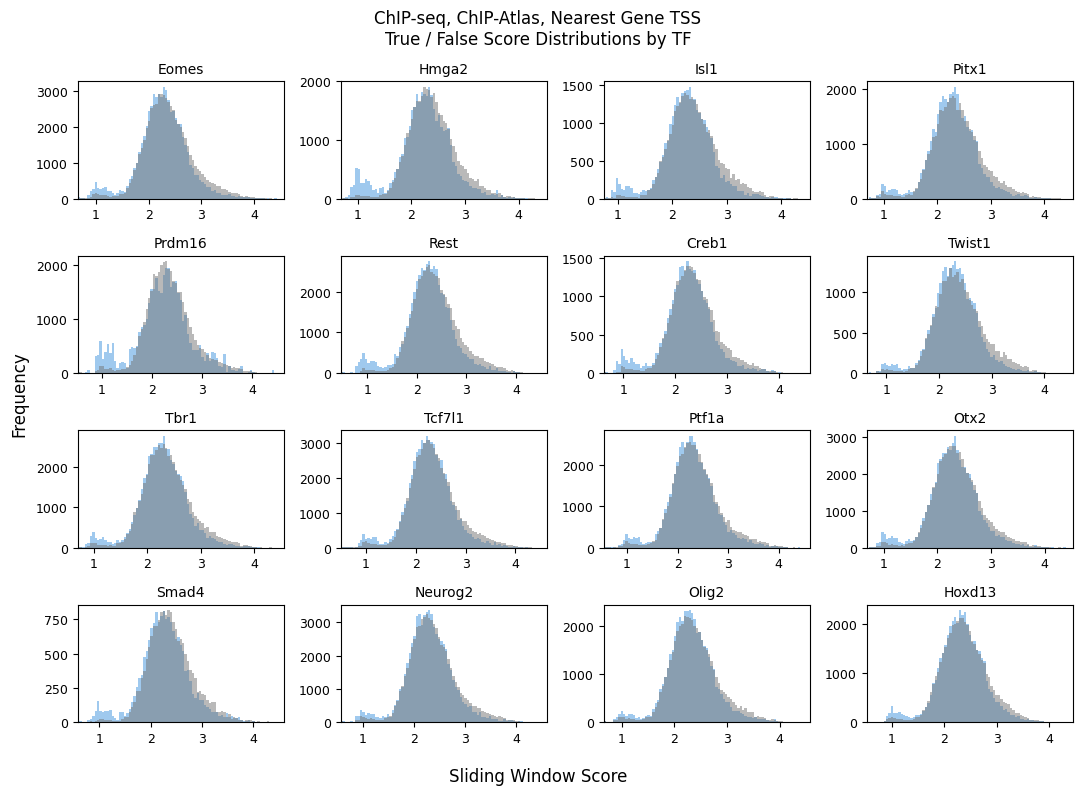

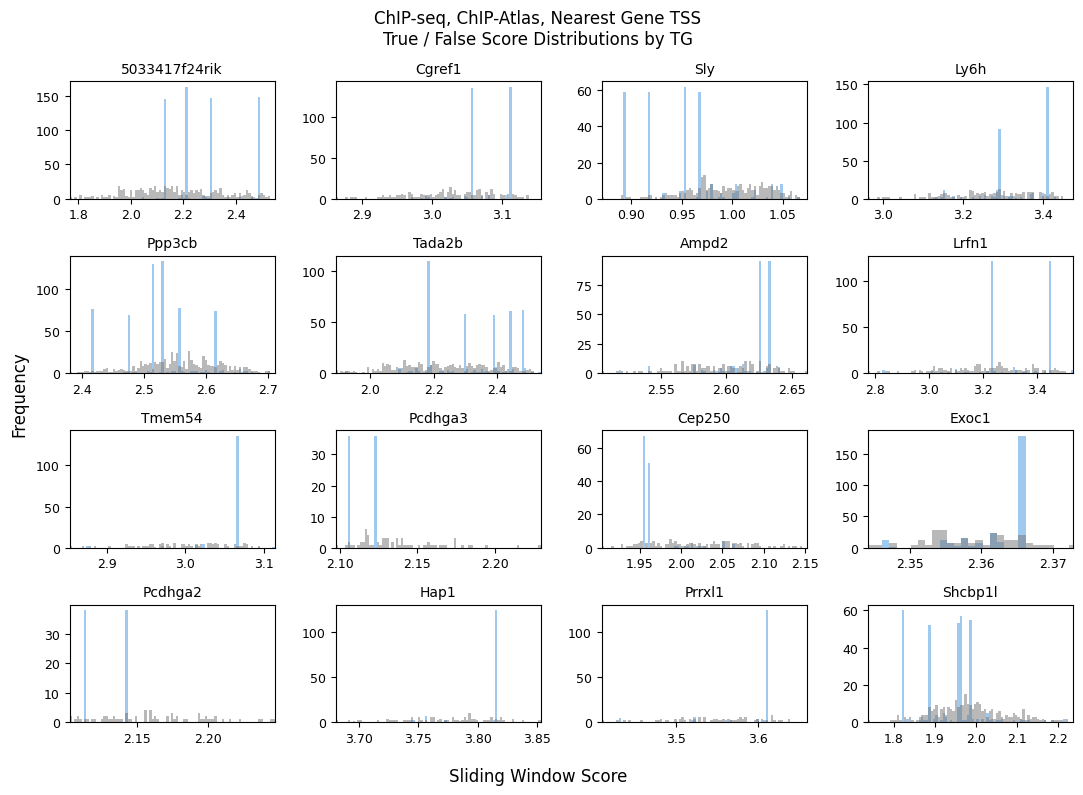

In [58]:
tf_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=chipseq_tf_mean_diff_df, 
    original_score_df=norm_df,
    group_col="source_id",
    sample_name="ChIP-seq",
    ground_truth_name=ground_truth_name,
    tg_label_name="Nearest Gene TSS"
    )
tf_fig.show()

tg_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=chipseq_tg_mean_diff_df, 
    original_score_df=norm_df,
    group_col="target_id",
    sample_name="ChIP-seq",
    ground_truth_name=ground_truth_name,
    tg_label_name="Nearest Gene TSS"
    )
tg_fig.show()

#### Plotting AUROC Curves for Individual TFs and TGs

In [61]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import warnings

def auc_by_group(
    df, 
    group_col="source_id", 
    score_col="sliding_window_score",
    label_col="label",
    min_pos=5, 
    min_neg=5, 
    bootstrap=None, 
    random_state=0,
):
    # Only drop rows missing the score or the label
    df = df.copy().dropna(subset=[score_col, label_col])

    rows = []
    rng = np.random.default_rng(random_state)

    for g, sub in df.groupby(group_col, observed=True, sort=False):
        y = sub[label_col].to_numpy(dtype=bool)
        s = sub[score_col].to_numpy()

        n_pos, n_neg = int(y.sum()), int((~y).sum())
        if (n_pos < min_pos) or (n_neg < min_neg):
            rows.append({group_col: g, "auc": np.nan, "auc_lo": np.nan, "auc_hi": np.nan,
                         "n": len(sub), "n_pos": n_pos, "n_neg": n_neg})
            continue

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            auc = roc_auc_score(y, s)

        lo = hi = np.nan
        if bootstrap:
            idx = rng.integers(0, len(sub), size=(bootstrap, len(sub)))
            auc_bs = []
            for i in range(bootstrap):
                yi, si = y[idx[i]], s[idx[i]]
                if 0 < yi.sum() < len(yi):
                    auc_bs.append(roc_auc_score(yi, si))
            if auc_bs:
                lo, hi = np.percentile(auc_bs, [2.5, 97.5])

        rows.append({group_col: g, "auc": auc, "auc_lo": lo, "auc_hi": hi,
                     "n": len(sub), "n_pos": n_pos, "n_neg": n_neg})

    return pd.DataFrame(rows)


# mesc_gene_tss_tf_tg_sum_rn111_tf_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="source_id", bootstrap=1000)
# mesc_gene_tss_tf_tg_sum_rn111_tg_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="target_id", bootstrap=1000)

# ds011_gene_tss_tf_tg_sum_rn111_tf_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="source_id", bootstrap=1000)
# ds011_gene_tss_tf_tg_sum_rn111_tg_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="target_id", bootstrap=1000)

chipseq_gene_tss_tf_tg_sum_chip_atlas_tf_auc_df = auc_by_group(chipseq_gene_tss_tf_tg_sum_chip_atlas_df, group_col="source_id", bootstrap=1000)
chipseq_gene_tss_tf_peak_tg_chip_atlas_tg_auc_df = auc_by_group(chipseq_gene_tss_tf_peak_tg_chip_atlas_df, group_col="target_id", bootstrap=1000)

In [62]:
print(chipseq_gene_tss_tf_tg_sum_chip_atlas_df.head())

  source_id target_id  tf_to_tg_peak_scores_summed  total_tf_score  \
0     Ascl1     Creb1                 77260.383075    1.779665e+06   
1     Ascl1      Ctcf                 20262.971885    1.779665e+06   
2     Ascl1      Ebf1                  5387.613780    1.779665e+06   
3     Ascl1      Ezh2                  3757.002643    1.779665e+06   
4     Ascl1     Gata1                  6665.459404    1.779665e+06   

   sliding_window_score  distance  label  
0          43412.888250       NaN  False  
1          11385.837075       NaN  False  
2           3027.319638       NaN  False  
3           2111.073352       NaN  False  
4           3745.345709       NaN  False  


In [63]:
print(chipseq_gene_tss_tf_tg_sum_chip_atlas_tf_auc_df.head())

  source_id       auc    auc_lo    auc_hi     n  n_pos  n_neg
0     Ascl1  0.682927  0.484119  0.863263    57     16     41
1      Cdx2  0.336466  0.152980  0.521979    52     14     38
2     Cebpa  0.582230  0.242439  0.806454   579    574      5
3     Creb1  0.481707  0.263081  0.669479    53     12     41
4      Ctcf       NaN       NaN       NaN  9386   9386      0


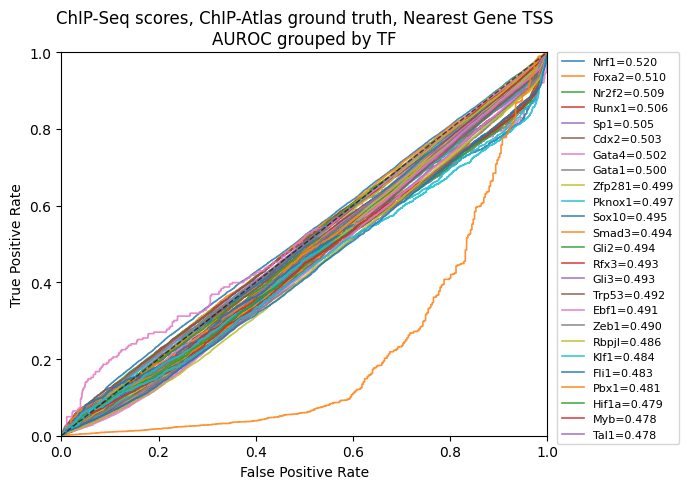

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_by_group(
    df: pd.DataFrame,
    group_col: str = "source_id",
    score_col: str = "sliding_window_score",
    label_col: str = "label",
    top_n: Union[int, None] = 20,          # None = plot all curves (can be very busy)
    min_pos: int = 1,
    min_neg: int = 1,
    sample_name: str="",
    ground_truth_name: str="",
    tg_label_name: str=""
    ):
    
    if group_col == "source_id":
        group_name = "TF"
    elif group_col == "target_id":
        group_name = "TG"
    else:
        group_name = group_col

    curves = []  # (group, fpr, tpr, auc)

    df = df.copy().dropna(subset=["source_id", "target_id", "sliding_window_score"])
    
    # compute ROC per group, skip groups without both classes
    for g, sub in df.groupby(group_col, observed=True):
        y = sub[label_col].astype(bool).to_numpy()
        s = sub[score_col].to_numpy()
        n_pos, n_neg = int(y.sum()), int((~y).sum())
        if n_pos < min_pos or n_neg < min_neg:
            continue

        fpr, tpr, _ = roc_curve(y, s)     # thresholds unused for plotting
        auc = roc_auc_score(y, s)
        curves.append((g, fpr, tpr, auc, n_pos, n_neg))

    if not curves:
        raise ValueError("No groups had both classes; cannot plot ROC curves.")

    # pick top-N by AUC if requested
    curves.sort(key=lambda x: x[3], reverse=True)
    if top_n is not None:
        curves = curves[:top_n]

    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    for g, fpr, tpr, auc, n_pos, n_neg in curves:
        ax.plot(fpr, tpr, lw=1.2, alpha=0.85, label=f"{g}={auc:.3f}")

    # baseline
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{sample_name} scores, {ground_truth_name} ground truth, {tg_label_name}\nAUROC grouped by {group_name}")
    
    h,l = ax.get_legend_handles_labels()

    if len(h) >= 25:
        ax.legend(h[:25], l[:25], bbox_to_anchor=(1.02, 1), ncols=1, loc="upper left", borderaxespad=0., fontsize=8)
    else:
        ax.legend(bbox_to_anchor=(1.02, 1), ncols=1, loc="upper left", borderaxespad=0., fontsize=8)
        
    fig.tight_layout()
    return fig

fig = plot_roc_by_group(chipseq_gene_tss_tf_peak_tg_chip_atlas_df,
                        group_col="source_id",
                        score_col="sliding_window_score",
                        label_col="label",
                        top_n=chipseq_gene_tss_tf_peak_tg_chip_atlas_df["source_id"].nunique(),
                        sample_name="ChIP-Seq",
                        ground_truth_name="ChIP-Atlas",
                        tg_label_name="Nearest Gene TSS"
                        )
fig.show()


In [ ]:
chipseq_gene_tss_tf_tg_sum_chip_atlas_df.groupby("source_id")